In [1]:
mname = 'hill_m94'
fold = 0

In [2]:
# hillclimbing on oofs from pytorch models with folds

glist = ['air_m68','airx_m67','cbam_m67','preresnet_m67']

dlist0 = ['airnet50_gwap','airnet50_gwap','airnext50_gwap','airnext50_gwap',
          'bn_inception_wgap','dpn68_gwap','resnet34_gwap',
          'se_resnext50_gwap']
dlist1 = ['ch_018','ch_028','ch_018','ch_030',
          'ch_042','ch_030','ch_042',
          'ch_030']

dlist = [i+'_'+j for i,j in zip(dlist0,dlist1)]

mnames = glist + dlist

# special = 'airnext50_gwap_ch_030'
special = 'airx_m67'

olist = []

gpct = 90.
gscale = 1.
# gscale = 10.
nfold = 4

In [3]:
import numpy as np
import pandas as pd
import pickle
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Reshape, Lambda, Activation
from keras.layers import UpSampling2D, Dropout, BatchNormalization, MaxPooling2D
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.applications import MobileNet

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.morphology import opening, closing

from scipy.special import logit, expit
import scipy.optimize as opt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.isotonic import IsotonicRegression

import gc
import cv2
from tqdm import tqdm_notebook

from sklearn.metrics import jaccard_similarity_score, f1_score, precision_score, recall_score

# from metrics import iou_metric, iou_metric_batch
# from metric import mean_iou

/home/sasrdw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
PATH_TO_TRAIN = './train/'
PATH_TO_TEST = './test/'
PATH_TO_TARGET = './train.csv'
PATH_TO_SUB = './sample_submission.csv'

LABEL_MAP = {
0: "Nucleoplasm" ,
1: "Nuclear membrane"   ,
2: "Nucleoli"   ,
3: "Nucleoli fibrillar center",   
4: "Nuclear speckles"   ,
5: "Nuclear bodies"   ,
6: "Endoplasmic reticulum"   ,
7: "Golgi apparatus"  ,
8: "Peroxisomes"   ,
9:  "Endosomes"   ,
10: "Lysosomes"   ,
11: "Intermediate filaments"  , 
12: "Actin filaments"   ,
13: "Focal adhesion sites"  ,
14: "Microtubules"   ,
15: "Microtubule ends"   ,
16: "Cytokinetic bridge"   ,
17: "Mitotic spindle"  ,
18: "Microtubule organizing center",  
19: "Centrosome",
20: "Lipid droplets"   ,
21: "Plasma membrane"  ,
22: "Cell junctions"   ,
23: "Mitochondria"   ,
24: "Aggresome"   ,
25: "Cytosol" ,
26: "Cytoplasmic bodies",
27: "Rods & rings"}

In [5]:
df = pd.read_csv(PATH_TO_TARGET)
df.set_index('Id',inplace=True)
print(df.head())
print(df.shape)

                                       Target
Id                                           
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
(31072, 1)


In [6]:
file_list = list(df.index.values)

ss = pd.read_csv(PATH_TO_SUB)
ss.set_index('Id',inplace=True)
print(ss.head())
print(ss.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [7]:
# train_df["images"] = [np.array(load_img("images/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                       for idx in tqdm_notebook(train_df.index)]

# train_df["masks"] = [np.array(load_img("masks/{}.png".format(idx), color_mode = "grayscale")) / 255 \
#                      for idx in tqdm_notebook(train_df.index)]

In [8]:
df.columns

Index(['Target'], dtype='object')

In [9]:
# estimate thresholds by line search
def F1_hard(preds, targs, th=0.5):
    return -f1_score(targs,  (preds>th).astype(int))

def fit_val1(x, y, start=0.5):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(F1_hard(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.3,0.7], method='bounded').x
#     p = opt.minimize_scalar(error, bounds=[0.1,0.9], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.01,0.99], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [10]:
oof = df.copy()
# print(oof.head())
# print(oof.shape)
eps = 1e-6
num_classes = 28
np.set_printoptions(precision=3,linewidth=80,suppress=True)

d = 0

for k,m in enumerate(mnames):
    print(' ')
    print(m)
    first = True
    for f in range(nfold):
        if m in dlist:
            if dlist0[d] == 'bn_inception_wgap': s = '_emb'
            else: s = '_extra_emb'
            o = pd.read_csv('oof/Dmytro/'+dlist0[d]+s+'__fold_'+
                            str(f)+'_'+dlist1[d]+'_oof.csv')
            # print(o.head(),o.shape)
            idf = list(o['Id'])
            pooff = np.array(o.iloc[:,:num_classes])
        else:        
            idf, pooff, yooff = pickle.load(open('oof/'+m+'_'+str(f)+'.pkl','rb'))
        
        # change to probability scale
        # reduce map to single number
        if m in dlist: 
            pooff = expit(pooff)
        else: 
            pooff = np.percentile(pooff, gpct, axis=(2,3))
            pooff = 1./(1. + np.exp(-pooff/gscale))
#             for i in range(num_classes):
#                 ir = IsotonicRegression()
#                 pooff[:,i] = ir.fit_transform(pooff[:,i],yooff[:,i])
         
#         print(pooff.shape)
        if first:
            id = idf
            folds = np.zeros(len(idf)).astype(int) + f
            poof = pooff.copy()
            yoof = yooff.copy()
            first = False
        else:
            id = id + idf
            folds = np.concatenate((folds, np.zeros(len(idf)).astype(int) + f))
            poof = np.concatenate((poof,pooff))
            yoof = np.concatenate((yoof,yooff))
    
#     # determine class-specific thresholds and convert predictions to binary
#     th = np.zeros(num_classes)
#     for i in range(num_classes):
#         th[i] = fit_val1(poof[:,i],yoof[:,i])
#     print('Thresholds: ',th)
#     poof = poof > th
#     print('F1 macro: ',f1_score(yoof, poof, average='macro'))

    mdf = pd.DataFrame({'Id':id})
    # print(poof.shape)
    if k==0: 
        mdf['fold'] = folds
        mdf['y'] = [yoof[i] for i in range(yoof.shape[0])]
    mdf[m] = [poof[i] for i in range(poof.shape[0])]
    mdf.set_index('Id',inplace=True)
    oof = oof.join(mdf)
                            
    if m in dlist: d += 1

 
air_m68
 
airx_m67
 
cbam_m67
 
preresnet_m67
 
airnet50_gwap_ch_018
 
airnet50_gwap_ch_028
 
airnext50_gwap_ch_018
 
airnext50_gwap_ch_030
 
bn_inception_wgap_ch_042
 
dpn68_gwap_ch_030
 
resnet34_gwap_ch_042
 
se_resnext50_gwap_ch_030


In [11]:
# print(oof.head())
print(oof.shape)

(31072, 15)


In [12]:
oof.columns

Index(['Target', 'fold', 'y', 'air_m68', 'airx_m67', 'cbam_m67',
       'preresnet_m67', 'airnet50_gwap_ch_018', 'airnet50_gwap_ch_028',
       'airnext50_gwap_ch_018', 'airnext50_gwap_ch_030',
       'bn_inception_wgap_ch_042', 'dpn68_gwap_ch_030', 'resnet34_gwap_ch_042',
       'se_resnext50_gwap_ch_030'],
      dtype='object')

In [13]:
vp = oof.loc[oof['y'].notnull()]
print(vp.shape)

(31072, 15)


In [14]:
# # compute rank transform separately for every column
# from scipy.stats import rankdata
# n = vp.shape[0] * 28
# for m in mnames:
#     a = rankdata(np.array(list(vp[m])).flatten()).reshape((vp.shape[0],28))/n
#     vp[m] = [i for i in a]
# print(vp.shape)

In [15]:
vp.head()

Target  fold  \
Id                                                    
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0     1   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0     2   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5     3   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1     1   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18     3   

                                                                                      y  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                                air_m68  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9345660852333681, 0.0008988497216182184, 0....   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9718787630406192, 0.9991793327454107, 0.091...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.9786827595622698, 0.009285109021214094, 0.8...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.7367792571344912, 0.997068648939479, 0.0029...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.9074854701800047, 0.0004360131866126043, 0....   

                                                                               airx_m67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.8656790571187407, 0.0014671903371832053, 0....   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9349515515313076, 0.996052685109876, 0.1593...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.9717814777899952, 0.012385942633981779, 0.8...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.9803320370327617, 0.9946726760045966, 0.010...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.34910936447266966, 0.01021111678227233, 0.1...   

                                                                               cbam_m67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.7439313236094636, 0.004164729114393892, 0.1...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.7942463677248243, 0.992784421024508, 0.6995...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.9564106540916972, 0.008861256582418073, 0.6...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.9536276775382528, 0.9940647010303076, 0.163...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.27687551406514965, 0.0003178064859566209, 0...   

                                                                          preresnet_m67  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.9863992277294257, 0.0025963403520444304, 0....   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.9121052907793671, 0.995573519896965, 0.0833...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.8546544320966802, 0.033203931524106826, 0.6...   
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0  [0.7770642777454769, 0.9936771865430427, 0.024...   
001838f8-bbca-11e8-b2bc-ac1f6b6435d0  [0.5362118739760604, 0.0006045644498060022, 0....   

                                                                   airnet50_gwap_ch_018  \
Id                                                                                        
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0  [0.34356144041983344, 0.0008367055380446142, 0...   
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  [0.1115856090648409, 0.9999625795578435, 0.074...   
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0  [0.2042937948631005, 0.010721593532432419, 0.2...   
000c99ba

In [16]:
offset = 3
nm = vp.shape[1] - offset
folds = oof['fold'].values.astype(int)
print(offset, nm, folds.shape)

3 12 (31072,)


In [17]:
y = np.array([a for a in vp.y])
y.shape

(31072, 28)

In [18]:
ys = np.sum(y,axis=1)
print(ys.shape)
print(ys.min(),ys.mean(),ys.max())

(31072,)
1.0 1.6343331 5.0


In [19]:
c_val = np.sum(y,axis=0)
for k,v in LABEL_MAP.items():
    print(k,v, 'count', c_val[k],
             'prop', '%6.4f' % (c_val[k]/y.shape[0]))

0 Nucleoplasm count 12885.0 prop 0.4147
1 Nuclear membrane count 1254.0 prop 0.0404
2 Nucleoli count 3621.0 prop 0.1165
3 Nucleoli fibrillar center count 1561.0 prop 0.0502
4 Nuclear speckles count 1858.0 prop 0.0598
5 Nuclear bodies count 2513.0 prop 0.0809
6 Endoplasmic reticulum count 1008.0 prop 0.0324
7 Golgi apparatus count 2822.0 prop 0.0908
8 Peroxisomes count 53.0 prop 0.0017
9 Endosomes count 45.0 prop 0.0014
10 Lysosomes count 28.0 prop 0.0009
11 Intermediate filaments count 1093.0 prop 0.0352
12 Actin filaments count 688.0 prop 0.0221
13 Focal adhesion sites count 537.0 prop 0.0173
14 Microtubules count 1066.0 prop 0.0343
15 Microtubule ends count 21.0 prop 0.0007
16 Cytokinetic bridge count 530.0 prop 0.0171
17 Mitotic spindle count 210.0 prop 0.0068
18 Microtubule organizing center count 902.0 prop 0.0290
19 Centrosome count 1482.0 prop 0.0477
20 Lipid droplets count 172.0 prop 0.0055
21 Plasma membrane count 3777.0 prop 0.1216
22 Cell junctions count 802.0 prop 0.0258
23

In [20]:
# idx = range(28)
# loc = [LABEL_MAP[j] for j in idx]
# lb = [c_val[j]/y.shape[0] for j in idx]

# df = pd.DataFrame({'idx':idx, 'loc':loc, 'training':lb})
# fname = 'train_props.csv'
# df.to_csv(fname,index=False)
# print(fname)

In [21]:
# train_sum_vec = np.sum(np.stack(subm['target_vec'].values, 0), 0)
# _ = plt.bar(n_keys, [train_sum_vec[k] for k in n_keys])

In [22]:
ymean = np.mean(y,axis=0)
print(ymean)

[0.415 0.04  0.117 0.05  0.06  0.081 0.032 0.091 0.002 0.001 0.001 0.035 0.022
 0.017 0.034 0.001 0.017 0.007 0.029 0.048 0.006 0.122 0.026 0.095 0.01  0.265
 0.011 0.   ]


In [23]:
ysum = np.sum(y,axis=0)
print(ysum)

[12885.  1254.  3621.  1561.  1858.  2513.  1008.  2822.    53.    45.    28.
  1093.   688.   537.  1066.    21.   530.   210.   902.  1482.   172.  3777.
   802.  2965.   322.  8228.   328.    11.]


(-0.03034705803458428, 0.4436122904074585)

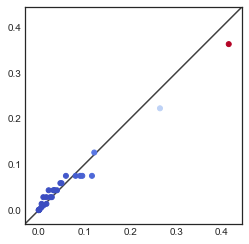

In [24]:
# plot training class frequencies versus those from leaderboard probing by iafoss
lb_prob = np.array([
0.36239782, 0.043841336, 0.075268817, 0.059322034, 0.075268817,
0.075268817, 0.043841336, 0.075268817, 0.0018, 0.0014,
0.0009, 0.043841336, 0.043841336, 0.014198783, 0.043841336,
0.0007, 0.028806584, 0.014198783, 0.028806584, 0.059322034,
0.0056, 0.126126126, 0.028806584, 0.075268817, 0.0104,
0.222493888, 0.028806584, 0.0004
])
   
# sns.regplot(ymean, lb_prob)

c = ymean**2 + lb_prob**2

fig, ax = plt.subplots()
ax.scatter(ymean, lb_prob, s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
# fig.savefig('/Users/paul/Desktop/so.png', dpi=300)

In [25]:
# lb probing resuluts from iafoss
# print lower and upper bound on frequencies
probe = {
0 : 0.019,
1 : 0.003,
2 : 0.005,
3 : 0.004,
4 : 0.005,
5 : 0.005,
6 : 0.003,
7 : 0.005,
8 : 0.000,
9 : 0.000,
10 : 0.000,
11 : 0.003,
12 : 0.003,
13 : 0.001,
14 : 0.003,
15 : 0.000,
16 : 0.002,
17 : 0.001,
18 : 0.002,
19 : 0.004,
20 : 0.000,
21 : 0.008,
22 : 0.002,
23 : 0.005,
24 : 0.000,
25 : 0.013,
26 : 0.002,
27 : 0.000
}

r = 0.000499
for k in range(28):

    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = np.round(fi*11702)
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,ysum[k]),LABEL_MAP[k])

0 0.3496 0.3624 0.3755 0.4147 4241 12885 Nucleoplasm
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
2 0.0673 0.0753 0.0834 0.1165 881 3621 Nucleoli
3 0.0515 0.0593 0.0672 0.0502 694 1561 Nucleoli fibrillar center
4 0.0673 0.0753 0.0834 0.0598 881 1858 Nuclear speckles
5 0.0673 0.0753 0.0834 0.0809 881 2513 Nuclear bodies
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
7 0.0673 0.0753 0.0834 0.0908 881 2822 Golgi apparatus
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
18 0.0215 0.0288 

In [26]:
order = np.argsort(ymean)
order

array([27, 15, 10,  9,  8, 20, 17, 24, 26, 16, 13, 12, 22, 18,  6, 14, 11,  1,
       19,  3,  4,  5,  7, 23,  2, 21, 25,  0])

In [27]:
# sort by training frequency
for j in range(28):
    k = order[j]
    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = np.round(fi*11702)
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,ysum[k]),LABEL_MAP[k])

27 0.0000 0.0000 0.0070 0.0004 0 11 Rods & rings
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
20 0.0000 0.0000 0.0070 0.0055 0 172 Lipid droplets
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
24 0.0000 0.0000 0.0070 0.0104 0 322 Aggresome
26 0.0215 0.0288 0.0363 0.0106 337 328 Cytoplasmic bodies
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
22 0.0215 0.0288 0.0363 0.0258 337 802 Cell junctions
18 0.0215 0.0288 0.0363 0.0290 337 902 Microtubule organizing center
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
19 0.0515 0.0593 0.

In [28]:
# save
ka = []
fi0a = []
fia = []
fi1a = []
yma = []
ca = []
for j in range(28):
    k = order[j]
    # si = 0.019*28
    si = probe[k]*28
    fi = si/(2-si)
    si0 = max(0,(probe[k] - r)*28)
    fi0 = si0/(2-si0)
    si1 = (probe[k] + r)*28
    fi1 = si1/(2-si1)
    ci = fi*11702.
    ka.append(k)
    fi0a.append(fi0)
    fia.append(fi)
    fi1a.append(fi1)
    yma.append(ymean[k])
    ca.append(LABEL_MAP[k])
    print(k,'%6.4f %6.4f %6.4f %6.4f %d %d' % (fi0,fi,fi1,ymean[k],ci,
                                               ysum[k]),LABEL_MAP[k])
              
tf = pd.DataFrame({'class':ka,'name':ca,'dataset':'test',
                   'fi0':fi0a,'freq':fia,'fi1':fi1a,'ym':yma})
fname = 'test_freq.csv'
tf.to_csv(fname,index=False)
print(fname)

27 0.0000 0.0000 0.0070 0.0004 0 11 Rods & rings
15 0.0000 0.0000 0.0070 0.0007 0 21 Microtubule ends
10 0.0000 0.0000 0.0070 0.0009 0 28 Lysosomes
9 0.0000 0.0000 0.0070 0.0014 0 45 Endosomes
8 0.0000 0.0000 0.0070 0.0017 0 53 Peroxisomes
20 0.0000 0.0000 0.0070 0.0055 0 172 Lipid droplets
17 0.0071 0.0142 0.0214 0.0068 166 210 Mitotic spindle
24 0.0000 0.0000 0.0070 0.0104 0 322 Aggresome
26 0.0215 0.0288 0.0363 0.0106 337 328 Cytoplasmic bodies
16 0.0215 0.0288 0.0363 0.0171 337 530 Cytokinetic bridge
13 0.0071 0.0142 0.0214 0.0173 166 537 Focal adhesion sites
12 0.0363 0.0438 0.0515 0.0221 513 688 Actin filaments
22 0.0215 0.0288 0.0363 0.0258 337 802 Cell junctions
18 0.0215 0.0288 0.0363 0.0290 337 902 Microtubule organizing center
6 0.0363 0.0438 0.0515 0.0324 513 1008 Endoplasmic reticulum
14 0.0363 0.0438 0.0515 0.0343 513 1066 Microtubules
11 0.0363 0.0438 0.0515 0.0352 513 1093 Intermediate filaments
1 0.0363 0.0438 0.0515 0.0404 513 1254 Nuclear membrane
19 0.0515 0.0593 0.

In [29]:
w = 1.0/np.mean(y,axis=0)
np.set_printoptions(precision=4,linewidth=80,suppress=True)
print(w)
print(w/sum(w))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1109.7142   28.4282   45.1628   57.8622
   29.1482 1479.6191   58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 2824.727 ]
[0.0003 0.0032 0.0011 0.0026 0.0022 0.0016 0.004  0.0014 0.0764 0.09   0.1446
 0.0037 0.0059 0.0075 0.0038 0.1928 0.0076 0.0193 0.0045 0.0027 0.0235 0.0011
 0.005  0.0014 0.0126 0.0005 0.0123 0.3681]


In [30]:
wc = np.clip(w,0.,1000.)
print(wc)
print(wc/sum(wc))

[   2.4115   24.7783    8.5811   19.9052   16.7234   12.3645   30.8254
   11.0106  586.2642  690.4889 1000.       28.4282   45.1628   57.8622
   29.1482 1000.       58.6264  147.9619   34.4479   20.9663  180.6512
    8.2266   38.7431   10.4796   96.4969    3.7764   94.7317 1000.    ]
[0.0005 0.0047 0.0016 0.0038 0.0032 0.0024 0.0059 0.0021 0.1115 0.1313 0.1901
 0.0054 0.0086 0.011  0.0055 0.1901 0.0111 0.0281 0.0066 0.004  0.0344 0.0016
 0.0074 0.002  0.0183 0.0007 0.018  0.1901]


In [31]:
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/74065 

import math

# mu in "create_class_weight" is a dampening parameter that could be tuned
def create_class_weight(labels_dict, mu=0.5):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    class_weight_log = dict()

    for key in keys:
        score = total / float(labels_dict[key])
        score_log = math.log(mu * total / float(labels_dict[key]))
        class_weight[key] = round(score, 2) if score > 1.0 else round(1.0, 2)
        class_weight_log[key] = round(score_log, 2) if score_log > 1.0 else round(1.0, 2)

    return class_weight, class_weight_log

# Class abundance for protein dataset
labels_dict = {
    0: 12885,
    1: 1254,
    2: 3621,
    3: 1561,
    4: 1858,
    5: 2513,
    6: 1008,
    7: 2822,
    8: 53,
    9: 45,
    10: 28,
    11: 1093,
    12: 688,
    13: 537,
    14: 1066,
    15: 21,
    16: 530,
    17: 210,
    18: 902,
    19: 1482,
    20: 172,
    21: 3777,
    22: 802,
    23: 2965,
    24: 322,
    25: 8228,
    26: 328,
    27: 11
}

ccw = create_class_weight(labels_dict, mu=1.0)
# print('\nTrue class weights:')
# print(create_class_weight(labels_dict)[0])
# print('\nLog-dampened class weights:')
# print(create_class_weight(labels_dict)[1])
for i in range(num_classes):
    print(i,ccw[0][i],ccw[1][i])

0 3.94 1.37
1 40.5 3.7
2 14.02 2.64
3 32.53 3.48
4 27.33 3.31
5 20.21 3.01
6 50.38 3.92
7 18.0 2.89
8 958.15 6.87
9 1128.49 7.03
10 1813.64 7.5
11 46.46 3.84
12 73.81 4.3
13 94.57 4.55
14 47.64 3.86
15 2418.19 7.79
16 95.82 4.56
17 241.82 5.49
18 56.3 4.03
19 34.27 3.53
20 295.24 5.69
21 13.45 2.6
22 63.32 4.15
23 17.13 2.84
24 157.71 5.06
25 6.17 1.82
26 154.82 5.04
27 4616.55 8.44


In [32]:
# results for single model designated as special
x = np.array([x for x in vp[special]])
x = np.clip(x,-20,20)
print(x.shape, x.min(), x.mean(), x.max())

(31072, 28) 2.669675996936083e-10 0.11898273495863106 0.9999998923631059


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


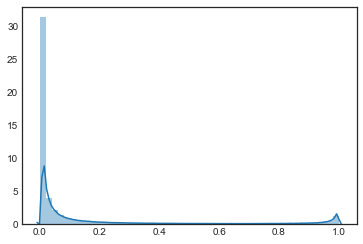

In [33]:
sns.distplot(x.flatten())

In [34]:
# t = -0.12
t = 0.5
xp = np.int32(x > t)
xps = np.sum(xp,axis=1)
print(xps.shape)
print(xps.min(),xps.mean(),xps.max())

(31072,)
0 2.748423017507724 8


In [35]:
print(np.mean(xp,axis=0))

[0.6197 0.0616 0.1725 0.0865 0.0826 0.1422 0.0801 0.1339 0.0014 0.0013 0.0011
 0.0558 0.0458 0.0313 0.0459 0.0007 0.046  0.0218 0.0667 0.1051 0.0074 0.214
 0.0591 0.1297 0.0151 0.5013 0.0197 0.0003]


In [36]:
# proportion of zero predictions
print(sum(xps==0)/x.shape[0])

0.0009976828012358393


In [37]:
f1_score(y, xp, average='macro')

0.5495215652338595

In [38]:
# make sure every image has at least one prediction
x1 = x.copy()
for i in range(x.shape[0]):
    x1[i,np.argmax(x[i])] = 30

In [39]:
t = 0.53
x1p = np.int32(x1 > t)
x1ps = np.sum(x1p,axis=1)
print(x1ps.shape)
print(x1ps.min(),x1ps.mean(),x1ps.max())

# proportion of zero predictions
print(sum(x1ps==0)/x1.shape[0])

f1_score(y, x1p, average='macro')

(31072,)
1 2.6548339340885683 8
0.0


0.5555589037475099

In [40]:
# custom thresholds to match observed proportions
thresholds = np.linspace(1.0, 0.0, 1001)
pred = x.copy()
for j in range(pred.shape[1]):
    for t in thresholds:
        pred[:,j] = (x[:,j] > t).astype(int)
        prop = np.mean(pred[:,j])
        if prop >= ymean[j]: break
    print(j,'%6.4f' % t,'%6.4f' % ymean[j],'%6.4f' % prop, LABEL_MAP[j])
print(f1_score(y, pred, average='macro'))

0 0.9240 0.4147 0.4148 Nucleoplasm
1 0.9020 0.0404 0.0404 Nuclear membrane
2 0.8170 0.1165 0.1166 Nucleoli
3 0.8660 0.0502 0.0503 Nucleoli fibrillar center
4 0.8070 0.0598 0.0598 Nuclear speckles
5 0.7900 0.0809 0.0810 Nuclear bodies
6 0.8960 0.0324 0.0325 Endoplasmic reticulum
7 0.7930 0.0908 0.0910 Golgi apparatus
8 0.2920 0.0017 0.0017 Peroxisomes
9 0.3730 0.0014 0.0014 Endosomes
10 0.7790 0.0009 0.0009 Lysosomes
11 0.8270 0.0352 0.0352 Intermediate filaments
12 0.8880 0.0221 0.0222 Actin filaments
13 0.8530 0.0173 0.0173 Focal adhesion sites
14 0.8860 0.0343 0.0344 Microtubules
15 0.5650 0.0007 0.0007 Microtubule ends
16 0.8630 0.0171 0.0171 Cytokinetic bridge
17 0.9610 0.0068 0.0068 Mitotic spindle
18 0.8740 0.0290 0.0292 Microtubule organizing center
19 0.8240 0.0477 0.0479 Centrosome
20 0.6690 0.0055 0.0056 Lipid droplets
21 0.8040 0.1216 0.1218 Plasma membrane
22 0.9010 0.0258 0.0258 Cell junctions
23 0.7840 0.0954 0.0956 Mitochondria
24 0.7820 0.0104 0.0104 Aggresome
25 0.8660

In [41]:
# estimate thresholds by least squares, from iafoss kernel
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.95*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params, maxfev=10000)
    return p

In [42]:
# #  pred = sigmoid_np(x)
# pred = x
# print(pred.min(),pred.mean(),pred.max())
# name_label_dict = LABEL_MAP
# th = fit_val(pred,y)
# # th[th<0.1] = 0.1
# print('Thresholds: ',th)
# print('F1 macro: ',f1_score(y, pred>th, average='macro'))
# # print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
# print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [43]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

2.669675996936083e-10 0.11898273495863106 0.9999998923631059 28
Thresholds:  [0.8547 0.9266 0.8338 0.8063 0.8538 0.8735 0.8952 0.8622 0.6143 0.5866 0.6157
 0.8982 0.8632 0.9487 0.847  0.3424 0.8491 0.7104 0.7148 0.8087 0.7742 0.7591
 0.896  0.8165 0.7882 0.7578 0.8097 0.3763]
F1 macro:  0.6041989025431677
F1 micro:  0.6832956114236343


In [44]:
# estimate thresholds by line search on observed proportions
def prop_mse(preds, targs, th=0.5):
    pm = np.mean((preds>th))
    tm = np.mean(targs)
#     print(th,pm,tm)
    return (tm - pm)**2
#     return (np.mean(targs) - np.mean((preds>th)))**2

def fit_val2(x, y, start=0.54):
    params = np.array([start])
    wd = 1e-5
#     error = lambda p: np.array(F1_hard(x,y,p), wd*(p - 0.5))
    error = lambda p: np.array(prop_mse(x,y,p))
#     p = opt.minimize_scalar(error, bounds=[0.,1.0], method='bounded').x
    p = opt.minimize_scalar(error, bounds=[0.4,0.6], method='bounded').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='brent').x
#     p = opt.minimize_scalar(error, bracket=[0.1,0.99], method='golden').x
    return p

In [45]:
# prop_mse(pred[:,0],y[:,0], 0.618)

In [46]:
# fit_val2(pred[:,0],y[:,0])

In [47]:
pred = x
num_classes = x.shape[1]
print(pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val2(pred[:,i],y[:,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

2.669675996936083e-10 0.11898273495863106 0.9999998923631059 28
Thresholds:  [0.5998 0.5977 0.5994 0.5996 0.599  0.5996 0.5996 0.5994 0.418  0.5236 0.5236
 0.5984 0.5971 0.5974 0.5984 0.5236 0.5984 0.5964 0.5997 0.5995 0.5931 0.5996
 0.5994 0.5989 0.5889 0.5998 0.5987 0.4764]
F1 macro:  0.5681825884504778
F1 micro:  0.6458359621451104


In [48]:
np.mean(pred[:,0] > 0.618)

0.5797180741503605

In [49]:
# model- and class-specific thresholds 
# compute best threshold to maximize f1 score by grid search

thresholds = np.linspace(0, 1.0, 101)

fm = [[f1_score(y[:,j], (x[:,j] > t).astype(int)) \
       for t in thresholds] for j in range(y.shape[1])]

besti = [np.argmax(f) for f in fm]
bestt = [thresholds[b] for b in besti]
bests = [f[b] for f,b in zip(fm,besti)]

# td = {}
# print(special)
# for j in range(y.shape[1]):
#     # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
#     plt.plot(thresholds, fm[j])
#     plt.plot(bestt[j], bests[j], "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
#     plt.title(LABEL_MAP[j] + " f1 vs threshold (%6.4f, %6.4f)" % (bestt[j], bests[j]))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()
 
print(special)
for j in range(y.shape[1]):
    print(j, "%5.3f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
    
print(np.mean(bests))   

airx_m67
0 0.870 0.8282 Nucleoplasm
1 0.910 0.7936 Nuclear membrane
2 0.780 0.7440 Nucleoli
3 0.850 0.6321 Nucleoli fibrillar center
4 0.850 0.6765 Nuclear speckles
5 0.870 0.5764 Nuclear bodies
6 0.900 0.4565 Endoplasmic reticulum
7 0.860 0.7147 Golgi apparatus
8 0.580 0.8454 Peroxisomes
9 0.440 0.9070 Endosomes
10 0.790 0.9091 Lysosomes
11 0.900 0.6814 Intermediate filaments
12 0.950 0.6418 Actin filaments
13 0.890 0.6393 Focal adhesion sites
14 0.860 0.8375 Microtubules
15 0.350 0.5455 Microtubule ends
16 0.920 0.3542 Cytokinetic bridge
17 0.870 0.2284 Mitotic spindle
18 0.740 0.3602 Microtubule organizing center
19 0.840 0.4770 Centrosome
20 0.780 0.4984 Lipid droplets
21 0.770 0.5898 Plasma membrane
22 0.900 0.5264 Cell junctions
23 0.810 0.7406 Mitochondria
24 0.800 0.4277 Aggresome
25 0.750 0.6403 Cytosol
26 0.890 0.4013 Cytoplasmic bodies
27 0.780 0.3077 Rods & rings
0.6064617899690814


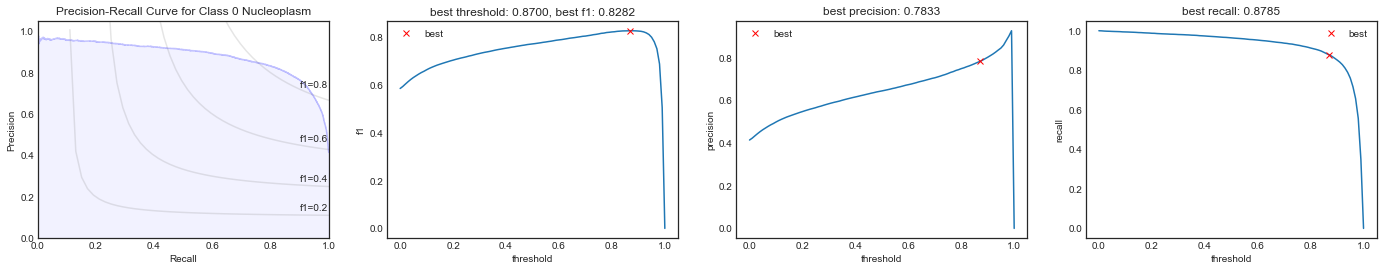

<Figure size 432x288 with 0 Axes>

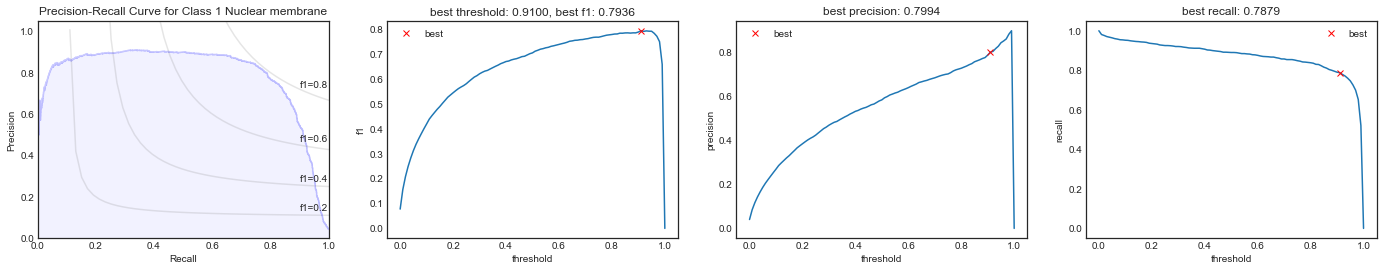

<Figure size 432x288 with 0 Axes>

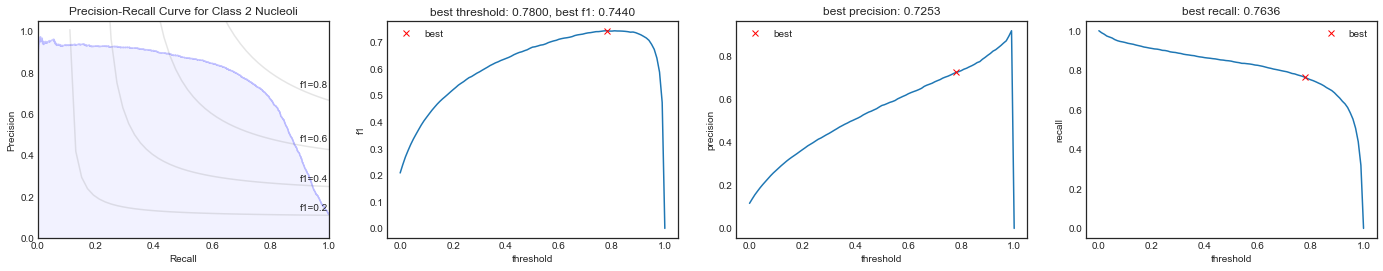

<Figure size 432x288 with 0 Axes>

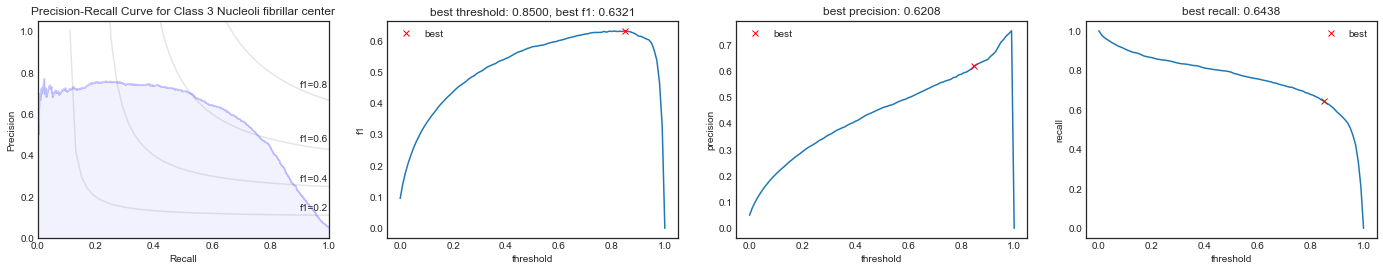

<Figure size 432x288 with 0 Axes>

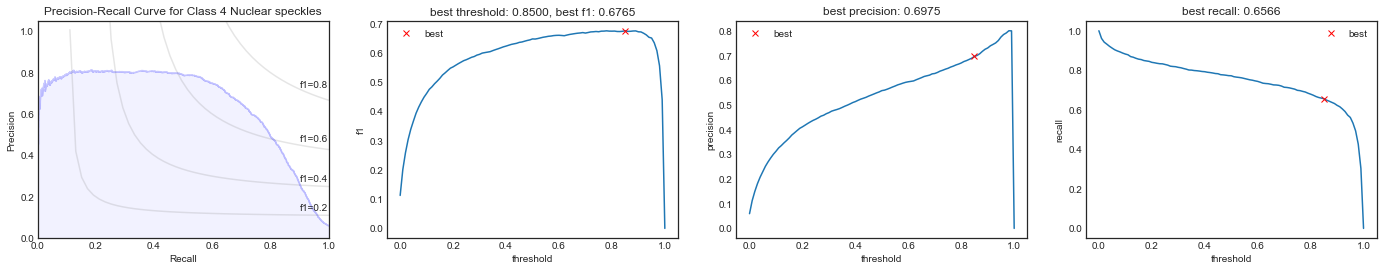

<Figure size 432x288 with 0 Axes>

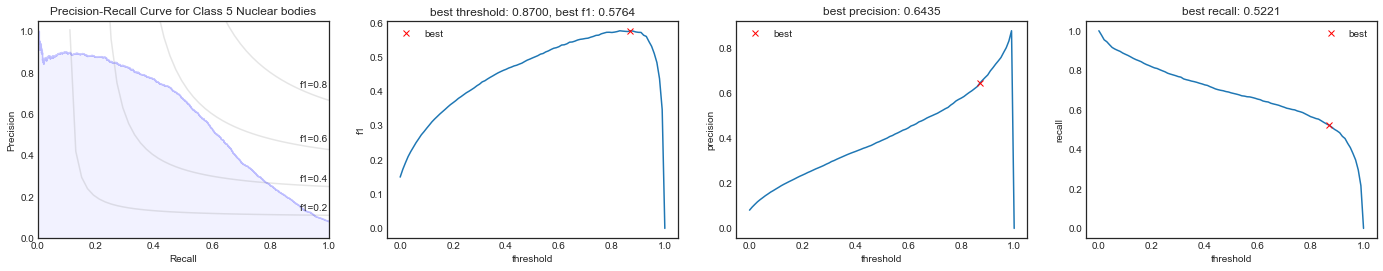

<Figure size 432x288 with 0 Axes>

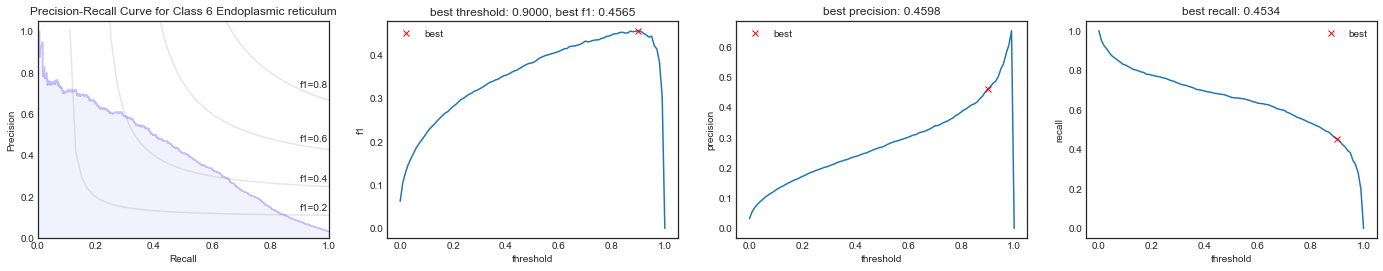

<Figure size 432x288 with 0 Axes>

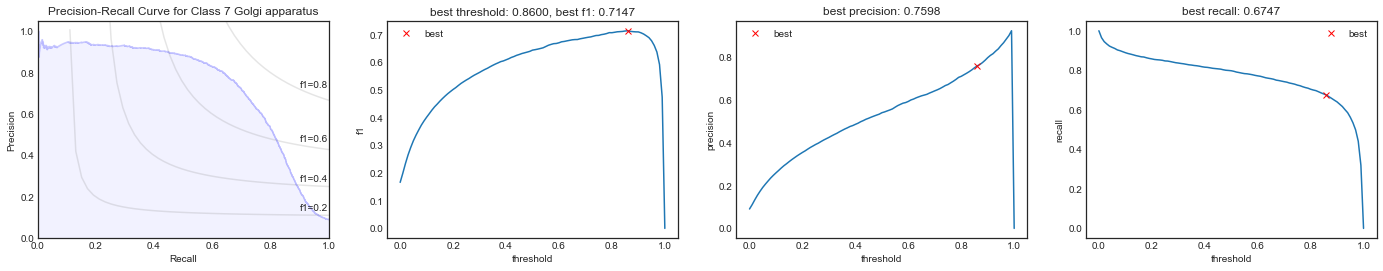

<Figure size 432x288 with 0 Axes>

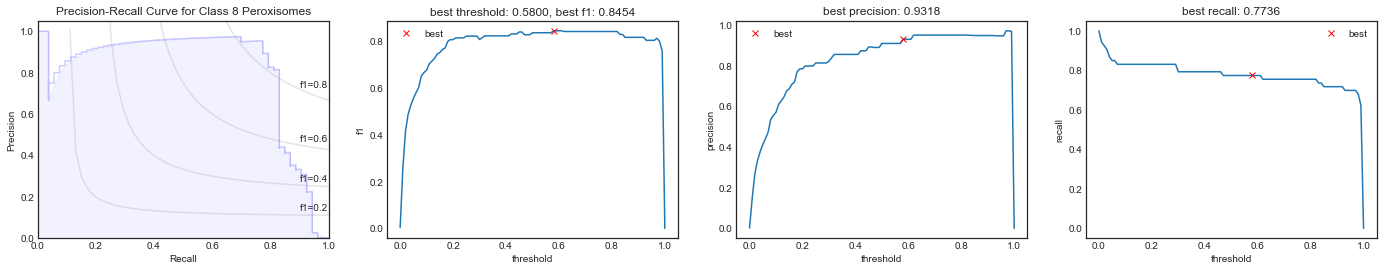

<Figure size 432x288 with 0 Axes>

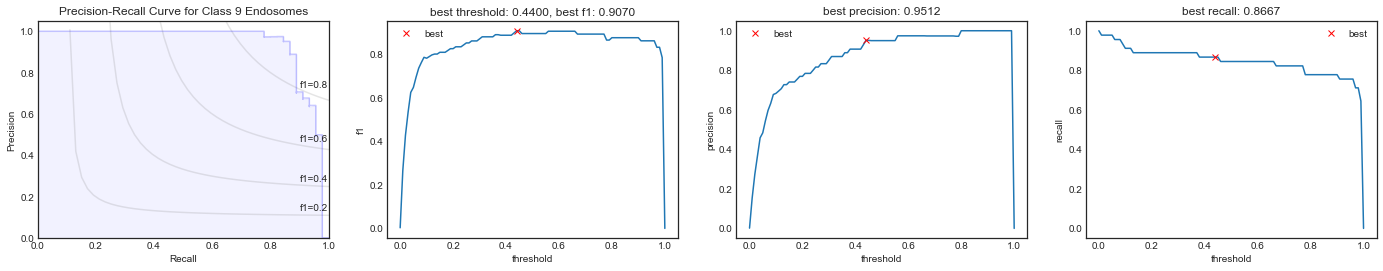

<Figure size 432x288 with 0 Axes>

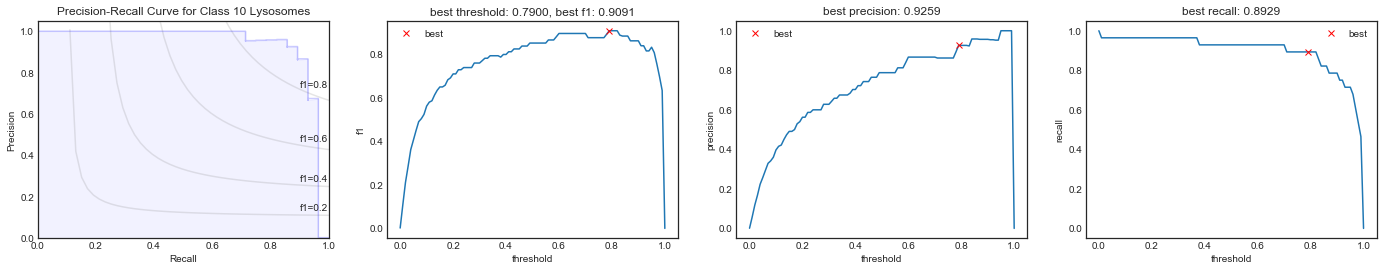

<Figure size 432x288 with 0 Axes>

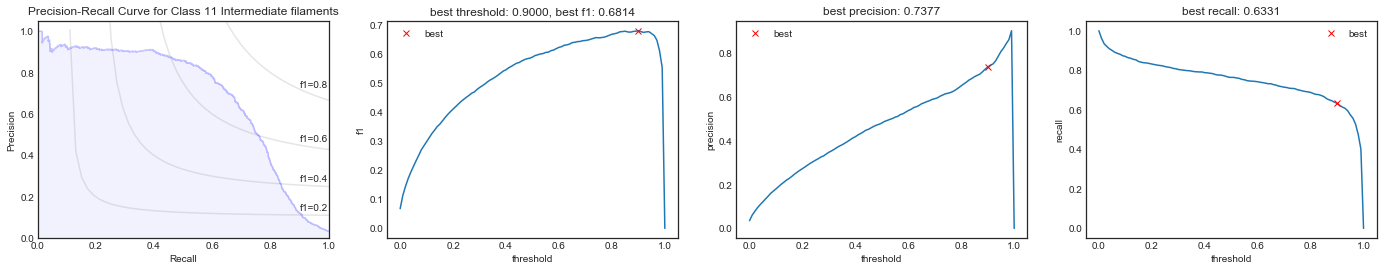

<Figure size 432x288 with 0 Axes>

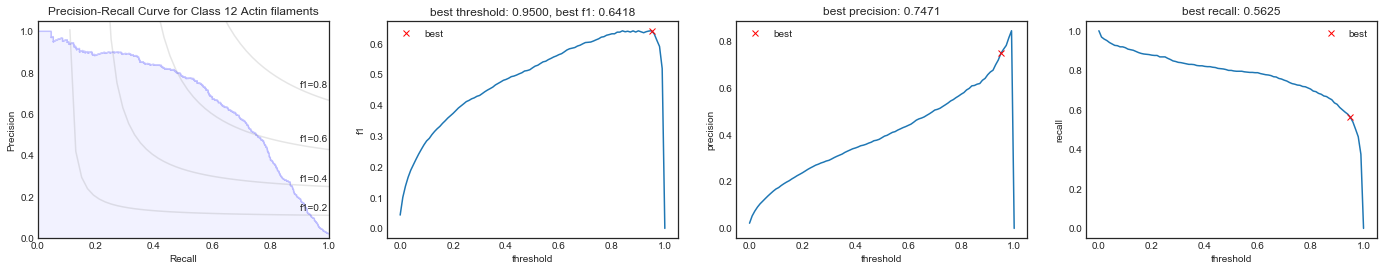

<Figure size 432x288 with 0 Axes>

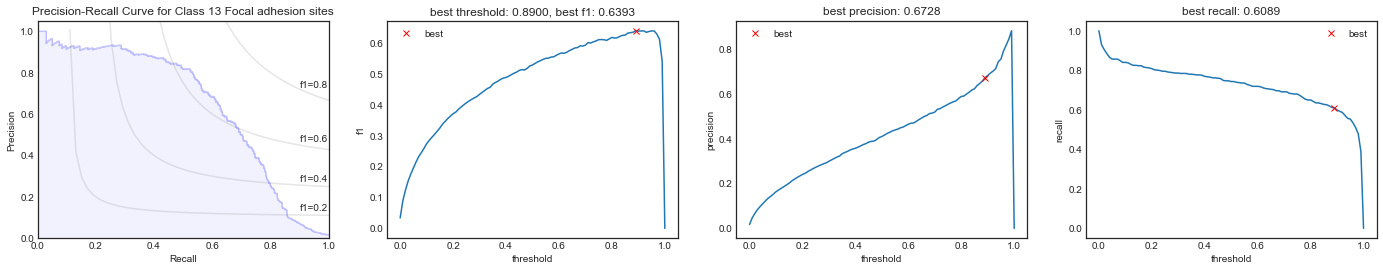

<Figure size 432x288 with 0 Axes>

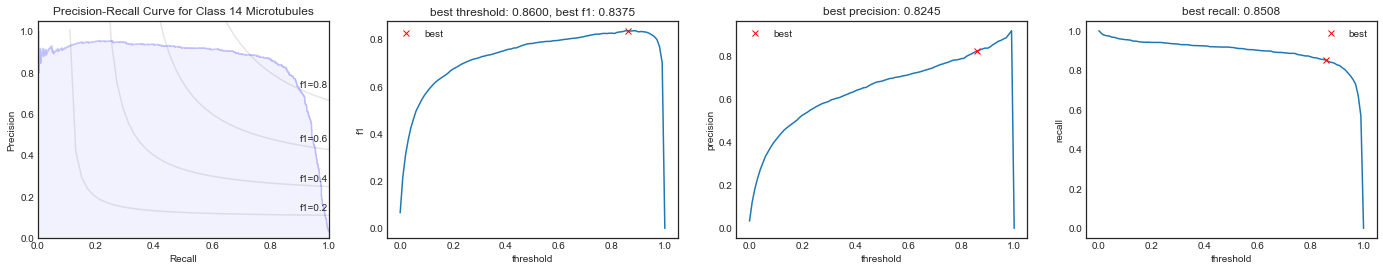

<Figure size 432x288 with 0 Axes>

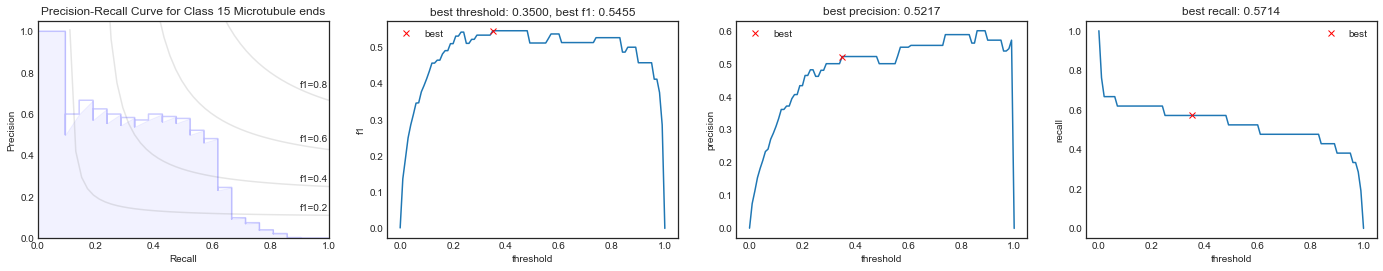

<Figure size 432x288 with 0 Axes>

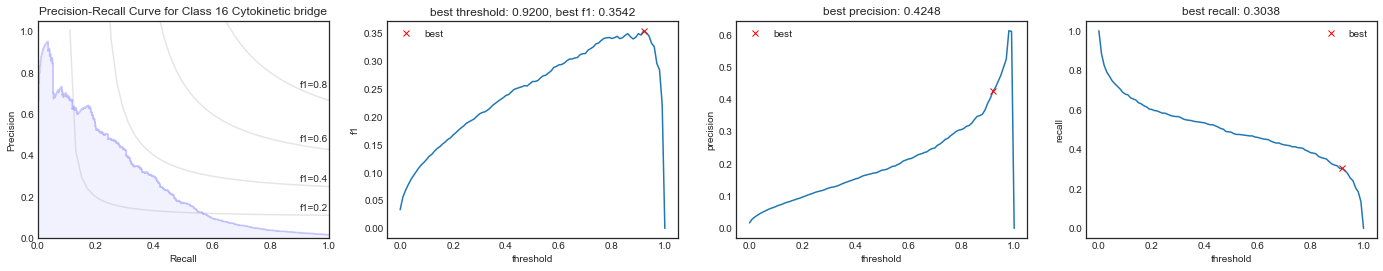

<Figure size 432x288 with 0 Axes>

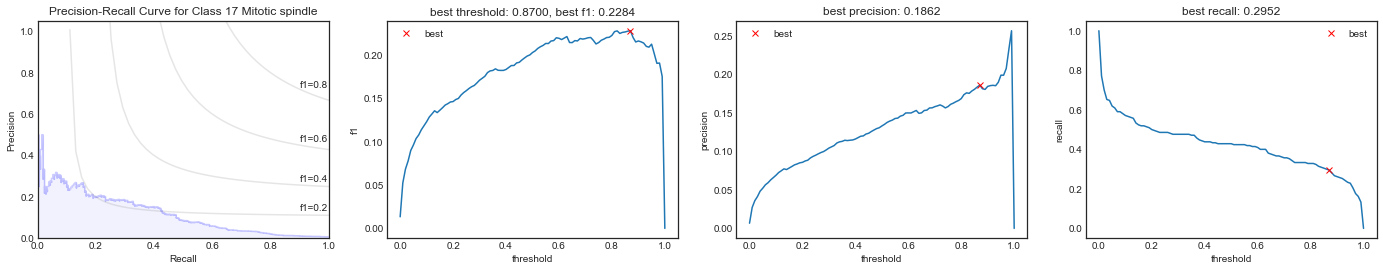

<Figure size 432x288 with 0 Axes>

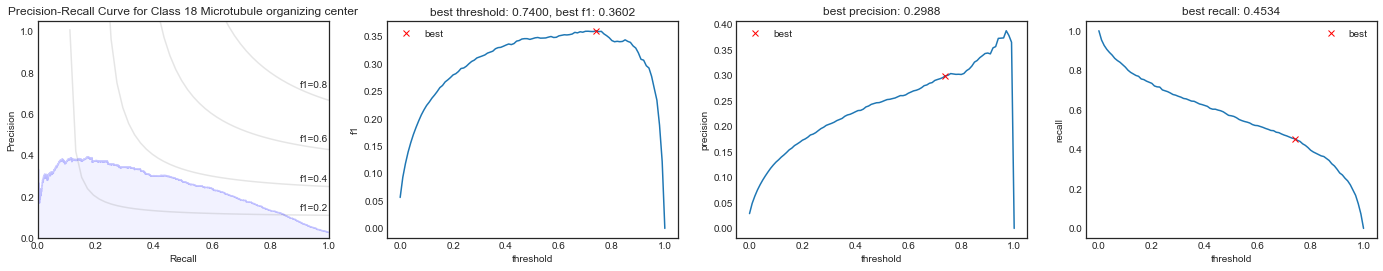

<Figure size 432x288 with 0 Axes>

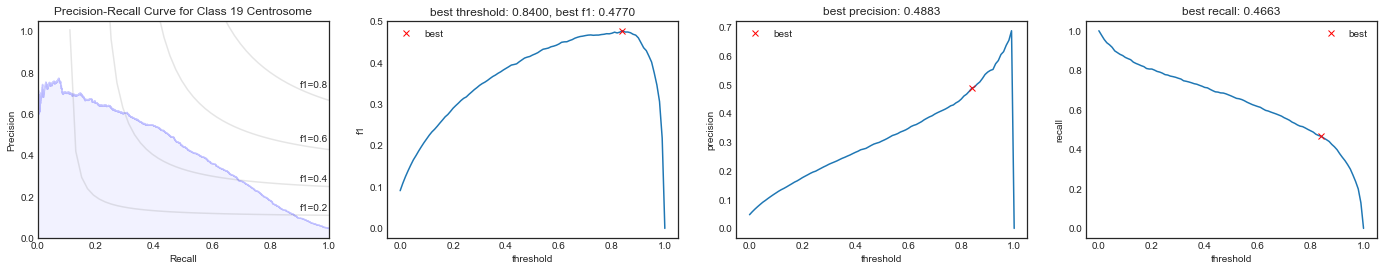

<Figure size 432x288 with 0 Axes>

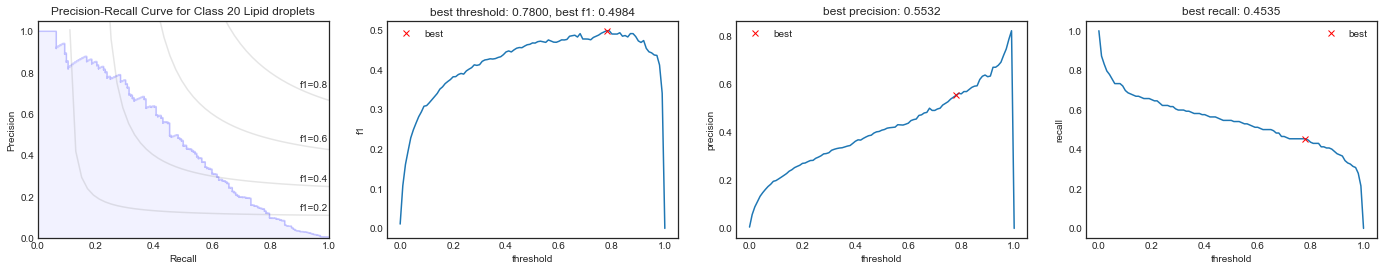

<Figure size 432x288 with 0 Axes>

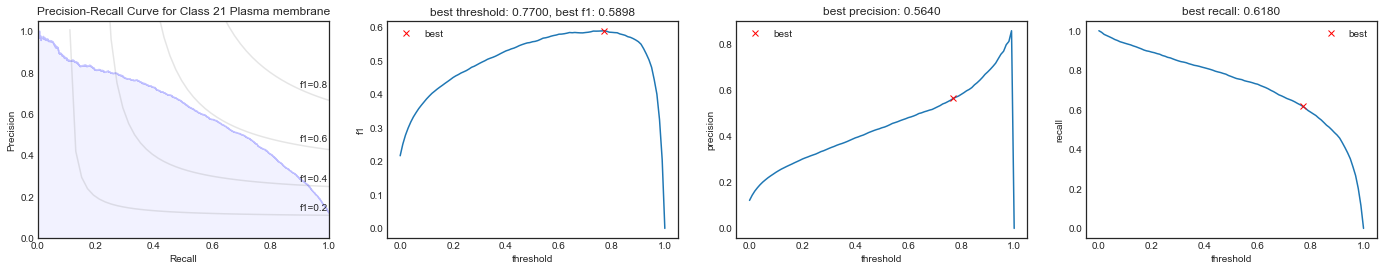

<Figure size 432x288 with 0 Axes>

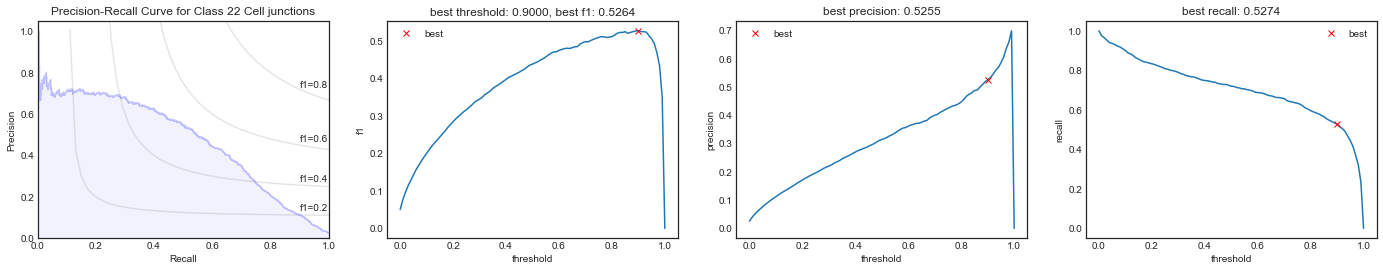

<Figure size 432x288 with 0 Axes>

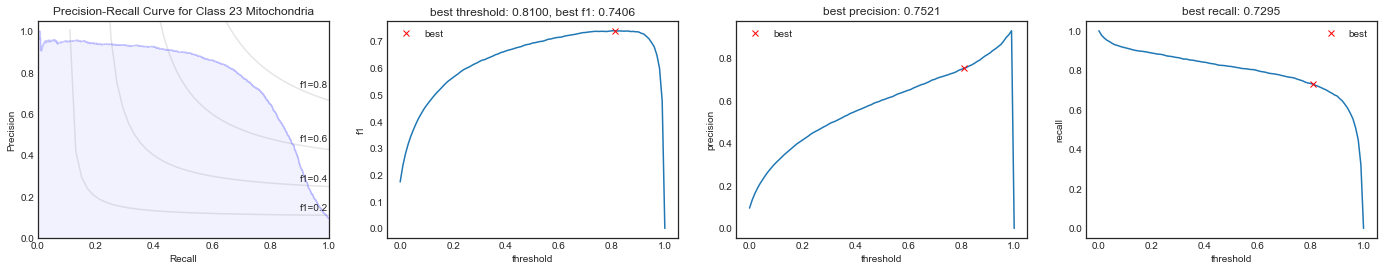

<Figure size 432x288 with 0 Axes>

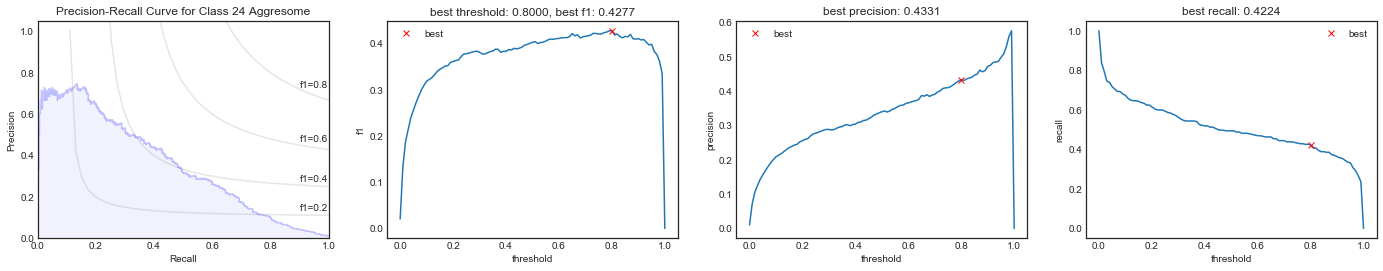

<Figure size 432x288 with 0 Axes>

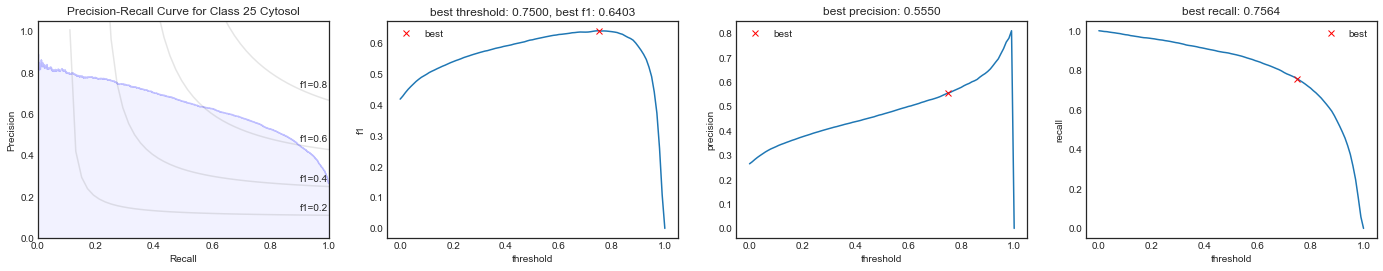

<Figure size 432x288 with 0 Axes>

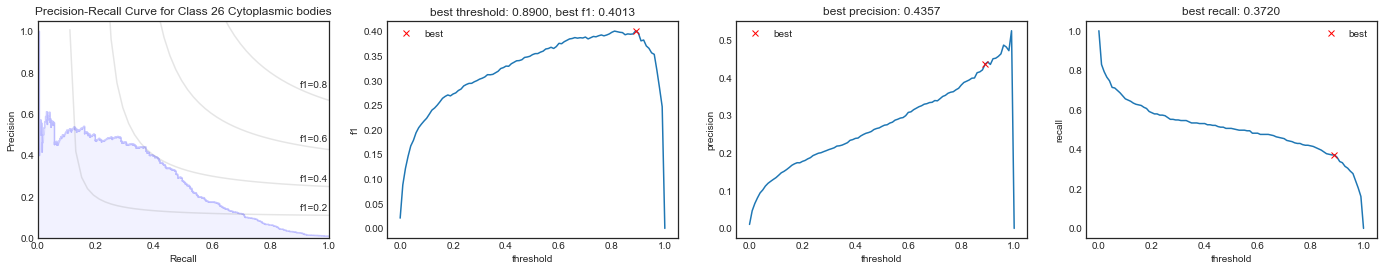

<Figure size 432x288 with 0 Axes>

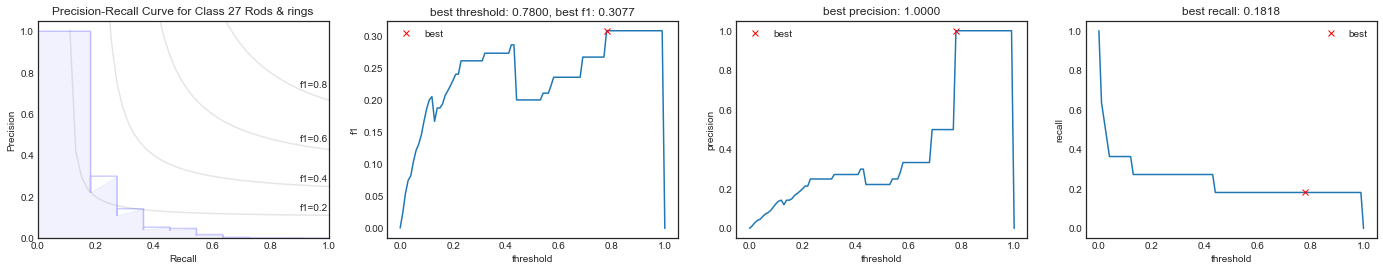

<Figure size 432x288 with 0 Axes>

In [50]:
n_classes = 28

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i], x[:, i])
    average_precision[i] = average_precision_score(y[:, i], x[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
#     thresholds = np.linspace(0.4, 0.6, 101)
    thresholds = np.linspace(0., 1.0, 101)
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    bests = fm[besti] 
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(y[:,i], (x[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [51]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), x.ravel())

average_precision["macro"] = average_precision_score(y, x, average="macro")
print('Average precision score, macro-averaged over all classes: {0:0.3f}'
      .format(average_precision["macro"]))

average_precision["micro"] = average_precision_score(y, x, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.3f}'
      .format(average_precision["micro"]))


Average precision score, macro-averaged over all classes: 0.585
Average precision score, micro-averaged over all classes: 0.704


In [52]:
# for i in range(len(th)):
#     print(i,np.round(th[i],decimals=2))

In [53]:
# print(np.mean(x > th,axis=0))

In [54]:
# f1_score(y, xp, average='samples')

In [55]:
f1_score(y, xp, average='micro')

0.6204683472731144

In [56]:
z = [(y,x) for y,x in zip(y,xp) if np.sum(x) == 0]
print(len(z))

31


In [57]:
# z[:5]

In [58]:
yz = np.array([t[0] for t in z])
xz = np.array([t[1] for t in z])
f1_score(yz,xz,average='macro')

0.0

0.0 0.6277073947693799 1.0


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


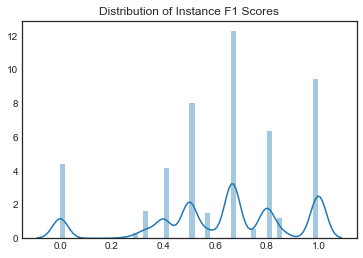

<Figure size 432x288 with 0 Axes>

In [59]:
f1b = np.array([f1_score(yi, xpi, average='binary') \
                 for yi,xpi in zip(y,xp)])
print(f1b.min(),f1b.mean(),f1b.max())
sns.distplot(f1b)
plt.title("Distribution of Instance F1 Scores")
plt.show()
plt.gcf().clear()

In [60]:
np.set_printoptions(precision=3, linewidth=200, suppress=True)
f = []
for m in mnames:
    ff = np.array(list(vp[m])).flatten()
    print(m, ff.shape)
    f.append(ff)
# print(mnames)
r = np.corrcoef(f)
print(r)   

air_m68 (870016,)
airx_m67 (870016,)
cbam_m67 (870016,)
preresnet_m67 (870016,)
airnet50_gwap_ch_018 (870016,)
airnet50_gwap_ch_028 (870016,)
airnext50_gwap_ch_018 (870016,)
airnext50_gwap_ch_030 (870016,)
bn_inception_wgap_ch_042 (870016,)
dpn68_gwap_ch_030 (870016,)
resnet34_gwap_ch_042 (870016,)
se_resnext50_gwap_ch_030 (870016,)
[[1.    0.896 0.87  0.891 0.787 0.794 0.793 0.797 0.796 0.795 0.826 0.813]
 [0.896 1.    0.871 0.893 0.787 0.794 0.793 0.797 0.795 0.795 0.829 0.816]
 [0.87  0.871 1.    0.876 0.778 0.785 0.783 0.788 0.788 0.785 0.823 0.81 ]
 [0.891 0.893 0.876 1.    0.786 0.792 0.79  0.794 0.795 0.794 0.829 0.815]
 [0.787 0.787 0.778 0.786 1.    0.965 0.951 0.935 0.928 0.947 0.861 0.867]
 [0.794 0.794 0.785 0.792 0.965 1.    0.95  0.945 0.932 0.947 0.858 0.861]
 [0.793 0.793 0.783 0.79  0.951 0.95  1.    0.963 0.929 0.949 0.857 0.864]
 [0.797 0.797 0.788 0.794 0.935 0.945 0.963 1.    0.926 0.942 0.852 0.854]
 [0.796 0.795 0.788 0.795 0.928 0.932 0.929 0.926 1.    0.942 0.8

In [61]:
loc = [i for i,m in enumerate(mnames) if m == special][0]
rloc = r[:,loc]
print(rloc)
order = np.argsort(rloc)
for i in range(1,min(len(rloc)+1,7)):
    print('%5.3f' % rloc[order[-i]],mnames[order[-i]])

[0.896 1.    0.871 0.893 0.787 0.794 0.793 0.797 0.795 0.795 0.829 0.816]
1.000 airx_m67
0.896 air_m68
0.893 preresnet_m67
0.871 cbam_m67
0.829 resnet34_gwap_ch_042
0.816 se_resnext50_gwap_ch_030


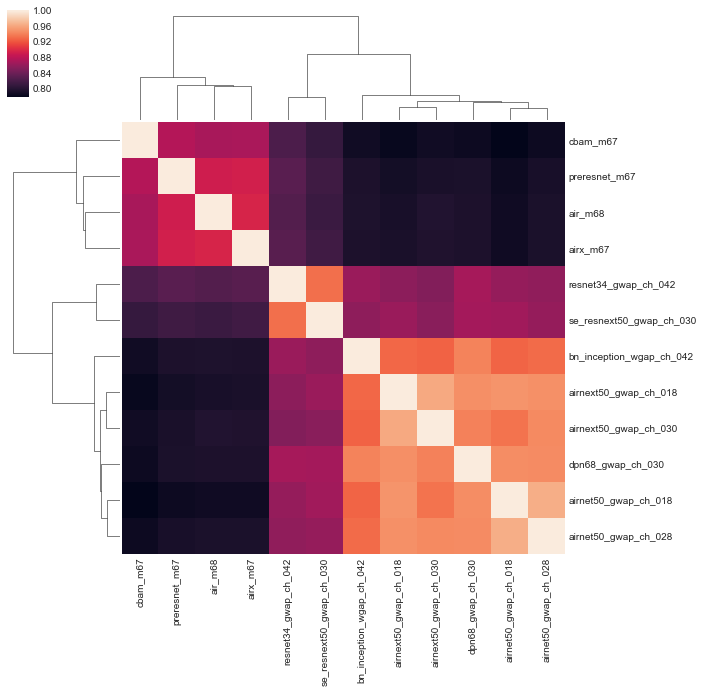

In [62]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [63]:
# f = []
# for m in mnames:
#     f.append(np.array(list(vp[m])).flatten())
# print(mnames)
# print(np.corrcoef(f))   

In [64]:
print(f[0].min(),f[0].max())

1.054523238486318e-12 0.9999994106696384


In [65]:
# # model-specific global thresholds
# # compute best single logit threshold for computed ensemble

# # for probabilities
# thresholds = np.linspace(0.1, 0.9, 1001)

# # for logits
# # thresholds = np.linspace(-1, 1, 101)

# # for ranks
# # thresholds = np.linspace(0.9, 1, 101)

# # thresholds = [-0.4]

# fname = 'mthresh.pkl'
# if os.path.isfile(fname): mthresh = pickle.load(open(fname,'rb'))
# else: mthresh = {}
# # mthresh = {}

# for i in range(nm):
# # for i in [3]:

#     mname = vp.columns[i+offset]

#     tv = np.array(list(vp.iloc[:,offset+i].values))
    
#     if mname in mthresh or np.sum(np.isnan(tv)) > 0: continue

#     scores = np.array([f1_score(y, np.int32(tv > threshold),
#                                  average='macro') for threshold in thresholds])

#     besta = np.argmax(scores)
#     threshold_best = thresholds[besta]
#     score_best = scores[besta]
#     print(i, mname, "%4.2f" % threshold_best, "%6.4f" % score_best)
#     mthresh[mname] = threshold_best
    
#     plt.plot(thresholds, scores)
#     plt.plot(threshold_best, score_best, "xr", label="best")
#     plt.xlabel("threshold")
#     plt.ylabel("f1")
# #     plt.title(mname + " f1 vs threshold (%6.4f, %6.4f)" % (threshold_best, score_best))
#     plt.title(mname + " threshold: %6.4f  f1: %6.4f" % (threshold_best, score_best))
#     plt.legend()
#     plt.show()
#     plt.gcf().clear()

# pickle.dump(mthresh,open(fname,'wb'))
# print(mthresh)

In [66]:
vp.columns

Index(['Target', 'fold', 'y', 'air_m68', 'airx_m67', 'cbam_m67',
       'preresnet_m67', 'airnet50_gwap_ch_018', 'airnet50_gwap_ch_028',
       'airnext50_gwap_ch_018', 'airnext50_gwap_ch_030',
       'bn_inception_wgap_ch_042', 'dpn68_gwap_ch_030', 'resnet34_gwap_ch_042',
       'se_resnext50_gwap_ch_030'],
      dtype='object')

In [67]:
# # model- and class-specific thresholds
# # compute best logit threshold for computed ensemble

# # thresholds = np.linspace(-2, 2, 101)

# # thresholds = [-0.4]

# fname = 'cthresh.pkl'
# # if os.path.isfile(fname): cthresh = pickle.load(open(fname,'rb'))
# cthresh = {}

# for i in range(nm):
# # for i in [2]:

#     mname = vp.columns[i+offset]
#     tv = np.array(list(vp.iloc[:,offset+i].values))

#     fm = [[f1_score(y[:,j], (tv[:,j] > t).astype(int)) \
#            for t in thresholds] for j in range(y.shape[1])]
    
#     besti = [np.argmax(f) for f in fm]
#     bestt = [thresholds[b] for b in besti]
#     bests = [f[b] for f,b in zip(fm,besti)]
#     print(mname, np.mean(bests))
    
#     td = {}
#     for j in range(y.shape[1]):
#         # print()
#         # print(j, LABEL_MAP[j], "%4.2f" % bestt[j], "%6.4f" % bests[j])
        
#         # print(j, "%4.2f" % bestt[j], "%6.4f" % bests[j], LABEL_MAP[j])
        
#         # print(cm[j], '%4.2f' % fm[j])
#         # print('')
#         td[j] = np.round(bestt[j],decimals=2)
    
#     cthresh[mname] = td
#     print()
    
# pickle.dump(cthresh,open(fname,'wb'))
# # print(cthresh)
# print(fname)



hillclimbing f1 fold 0 class 0 Nucleoplasm

model 0 f1 0.8312 0.866 0.8149 0.921 air_m68
model 1 f1 0.8337 0.847 0.8187 0.915 airx_m67
model 2 f1 0.8305 0.842 0.8165 0.888 cbam_m67
model 3 f1 0.8267 0.850 0.8089 0.881 preresnet_m67
model 4 f1 0.8080 0.315 0.7727 0.265 airnet50_gwap_ch_018
model 5 f1 0.8205 0.390 0.7800 0.311 airnet50_gwap_ch_028
model 6 f1 0.8176 0.334 0.7722 0.311 airnext50_gwap_ch_018
model 7 f1 0.8266 0.373 0.8043 0.270 airnext50_gwap_ch_030
model 8 f1 0.8303 0.356 0.7936 0.379 bn_inception_wgap_ch_042
model 9 f1 0.8283 0.320 0.7926 0.284 dpn68_gwap_ch_030
model 10 f1 0.8171 0.448 0.7841 0.430 resnet34_gwap_ch_042
model 11 f1 0.8079 0.422 0.7586 0.400 se_resnext50_gwap_ch_030
step = 0   index = 1   name = airx_m67    f1 = 0.8337  oof = 0.8187*
step = 1   index = 9   name = dpn68_gwap_ch_030    f1 = 0.8442  oof = 0.8119
step = 2   index = 2   name = cbam_m67    f1 = 0.8502  oof = 0.8206*
step = 3   index = 1   name = airx_m67    f1 = 0.8503  oof = 0.8224*
step = 4 

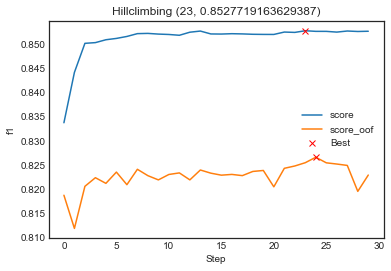

    step  midx     score  score_oof                       mod      f1_0
0      0     1  0.833735   0.818740                  airx_m67  0.833735
1      1     9  0.844155   0.811875         dpn68_gwap_ch_030  0.828268
2      2     2  0.850167   0.820585                  cbam_m67  0.830502
3      3     1  0.850316   0.822367                  airx_m67  0.833735
4      4     8  0.850908   0.821198  bn_inception_wgap_ch_042  0.830308
5      5     0  0.851184   0.823529                   air_m68  0.831174
6      6     7  0.851590   0.820924     airnext50_gwap_ch_030  0.826647
7      7     3  0.852173   0.824108             preresnet_m67  0.826684
8      8     1  0.852222   0.822789                  airx_m67  0.833735
9      9     7  0.852081   0.821914     airnext50_gwap_ch_030  0.826647
10    10     0  0.852000   0.823035                   air_m68  0.831174
11    11     1  0.851834   0.823360                  airx_m67  0.833735
12    12     8  0.852470   0.821918  bn_inception_wgap_ch_042  0

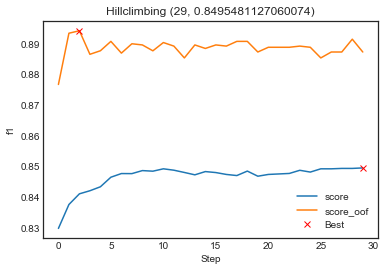

   step  midx     score  score_oof                    mod      f1_0
0     0     7  0.829822   0.876761  airnext50_gwap_ch_030  0.829822
1     1     2  0.837616   0.893471               cbam_m67  0.798345
2     2     5  0.841102   0.894281   airnet50_gwap_ch_028  0.819058

      weight                    mod      f1_0
midx                                         
2          1               cbam_m67  0.798345
5          1   airnet50_gwap_ch_028  0.819058
7          1  airnext50_gwap_ch_030  0.829822


hillclimbing f1 fold 0 class 2 Nucleoli

model 0 f1 0.7474 0.807 0.7599 0.791 air_m68
model 1 f1 0.7375 0.812 0.7705 0.780 airx_m67
model 2 f1 0.7375 0.831 0.7672 0.742 cbam_m67
model 3 f1 0.7461 0.815 0.7419 0.872 preresnet_m67
model 4 f1 0.7614 0.399 0.7665 0.259 airnet50_gwap_ch_018
model 5 f1 0.7655 0.348 0.7655 0.380 airnet50_gwap_ch_028
model 6 f1 0.7677 0.381 0.7636 0.242 airnext50_gwap_ch_018
model 7 f1 0.7646 0.439 0.7637 0.354 airnext50_gwap_ch_030
model 8 f1 0.7361 0.462 0.7607 0

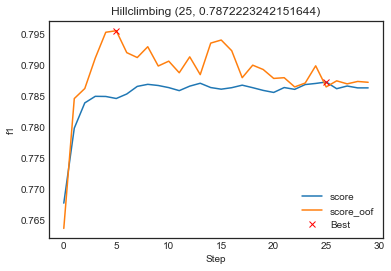

   step  midx     score  score_oof                    mod      f1_0
0     0     6  0.767707   0.763636  airnext50_gwap_ch_018  0.767707
1     1     0  0.779790   0.784558                air_m68  0.747409
2     2     1  0.783858   0.786172               airx_m67  0.737454
3     3     5  0.784918   0.791083   airnet50_gwap_ch_028  0.765459
4     4     0  0.784894   0.795241                air_m68  0.747409
5     5     3  0.784567   0.795483          preresnet_m67  0.746072

      weight                    mod      f1_0
midx                                         
0          2                air_m68  0.747409
1          1               airx_m67  0.737454
3          1          preresnet_m67  0.746072
5          1   airnet50_gwap_ch_028  0.765459
6          1  airnext50_gwap_ch_018  0.767707


hillclimbing f1 fold 0 class 3 Nucleoli fibrillar center

model 0 f1 0.6472 0.944 0.6813 0.780 air_m68
model 1 f1 0.6302 0.850 0.6619 0.728 airx_m67
model 2 f1 0.6382 0.897 0.6667 0.757 cbam_m67
mode

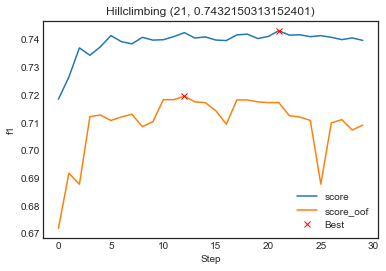

    step  midx     score  score_oof                    mod      f1_0
0      0     6  0.718477   0.671785  airnext50_gwap_ch_018  0.718477
1      1     4  0.726517   0.691729   airnet50_gwap_ch_018  0.715581
2      2     3  0.737016   0.687747          preresnet_m67  0.671457
3      3     1  0.734349   0.712177               airx_m67  0.630208
4      4     4  0.737416   0.712766   airnet50_gwap_ch_018  0.715581
5      5     6  0.741480   0.710801  airnext50_gwap_ch_018  0.718477
6      6     4  0.739257   0.712042   airnet50_gwap_ch_018  0.715581
7      7     1  0.738487   0.713043               airx_m67  0.630208
8      8     6  0.740833   0.708551  airnext50_gwap_ch_018  0.718477
9      9     7  0.739827   0.710345  airnext50_gwap_ch_030  0.702391
10    10     0  0.739975   0.718310                air_m68  0.647233
11    11     4  0.741108   0.718310   airnet50_gwap_ch_018  0.715581
12    12     4  0.742525   0.719577   airnet50_gwap_ch_018  0.715581

      weight                    m

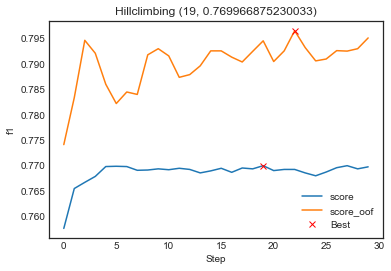

    step  midx     score  score_oof                    mod      f1_0
0      0     5  0.757631   0.774112   airnet50_gwap_ch_028  0.757631
1      1     7  0.765477   0.783354  airnext50_gwap_ch_030  0.752932
2      2     2  0.766691   0.794621               cbam_m67  0.675000
3      3     5  0.767857   0.792079   airnet50_gwap_ch_028  0.757631
4      4     5  0.769797   0.785982   airnet50_gwap_ch_028  0.757631
5      5     9  0.769853   0.782190      dpn68_gwap_ch_030  0.728100
6      6     5  0.769795   0.784461   airnet50_gwap_ch_028  0.757631
7      7     7  0.769062   0.783981  airnext50_gwap_ch_030  0.752932
8      8     0  0.769116   0.791768                air_m68  0.660926
9      9     6  0.769345   0.792974  airnext50_gwap_ch_018  0.740741
10    10     6  0.769174   0.791557  airnext50_gwap_ch_018  0.740741
11    11     7  0.769458   0.787342  airnext50_gwap_ch_030  0.752932
12    12    10  0.769231   0.787879   resnet34_gwap_ch_042  0.712601
13    13     5  0.768549   0.78960

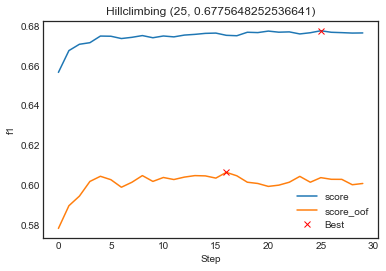

    step  midx     score  score_oof                       mod      f1_0
0      0     9  0.656650   0.578265         dpn68_gwap_ch_030  0.656650
1      1     8  0.667594   0.589666  bn_inception_wgap_ch_042  0.651350
2      2    11  0.670773   0.594484  se_resnext50_gwap_ch_030  0.646617
3      3     4  0.671563   0.601861      airnet50_gwap_ch_018  0.647263
4      4     6  0.674892   0.604454     airnext50_gwap_ch_018  0.653949
5      5     9  0.674801   0.602740         dpn68_gwap_ch_030  0.656650
6      6    11  0.673648   0.598953  se_resnext50_gwap_ch_030  0.646617
7      7     5  0.674260   0.601442      airnet50_gwap_ch_028  0.655202
8      8     1  0.675137   0.604797                  airx_m67  0.584140
9      9    11  0.674049   0.601881  se_resnext50_gwap_ch_030  0.646617
10    10     9  0.674928   0.603850         dpn68_gwap_ch_030  0.656650
11    11     8  0.674485   0.602823  bn_inception_wgap_ch_042  0.651350
12    12    10  0.675384   0.604040      resnet34_gwap_ch_042  0

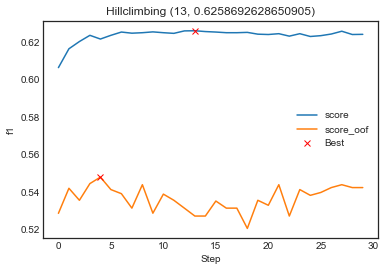

   step  midx     score  score_oof                       mod      f1_0
0     0    11  0.606241   0.528662  se_resnext50_gwap_ch_030  0.606241
1     1     4  0.616262   0.542005      airnet50_gwap_ch_018  0.594901
2     2     6  0.620123   0.535613     airnext50_gwap_ch_018  0.604493
3     3    11  0.623431   0.544503  se_resnext50_gwap_ch_030  0.606241
4     4     4  0.621453   0.547945      airnet50_gwap_ch_018  0.594901

      weight                       mod      f1_0
midx                                            
4          2      airnet50_gwap_ch_018  0.594901
6          1     airnext50_gwap_ch_018  0.604493
11         2  se_resnext50_gwap_ch_030  0.606241


hillclimbing f1 fold 0 class 7 Golgi apparatus

model 0 f1 0.6919 0.831 0.7781 0.759 air_m68
model 1 f1 0.6810 0.884 0.8007 0.766 airx_m67
model 2 f1 0.6854 0.773 0.7728 0.902 cbam_m67
model 3 f1 0.6937 0.797 0.7667 0.754 preresnet_m67
model 4 f1 0.7067 0.313 0.8387 0.381 airnet50_gwap_ch_018
model 5 f1 0.7243 0.425 0.8353 0

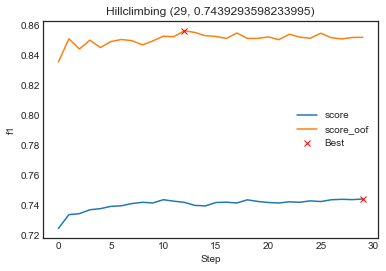

    step  midx     score  score_oof                       mod      f1_0
0      0     5  0.724312   0.835328      airnet50_gwap_ch_028  0.724312
1      1     9  0.733487   0.850772         dpn68_gwap_ch_030  0.716854
2      2     2  0.734163   0.844005                  cbam_m67  0.685365
3      3    10  0.736754   0.849825      resnet34_gwap_ch_042  0.709696
4      4     5  0.737493   0.844957      airnet50_gwap_ch_028  0.724312
5      5     8  0.739008   0.848937  bn_inception_wgap_ch_042  0.703767
6      6     6  0.739417   0.850286     airnext50_gwap_ch_018  0.709753
7      7     2  0.740885   0.849537                  cbam_m67  0.685365
8      8     4  0.741722   0.846690      airnet50_gwap_ch_018  0.706720
9      9     6  0.741309   0.849363     airnext50_gwap_ch_018  0.709753
10    10     0  0.743441   0.852478                   air_m68  0.691930
11    11    11  0.742479   0.852174  se_resnext50_gwap_ch_030  0.702875
12    12     1  0.741704   0.856136                  airx_m67  0

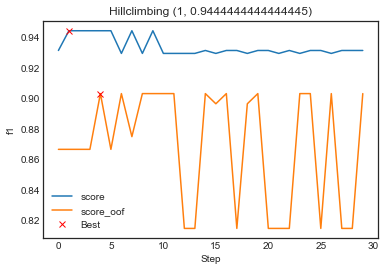

   step  midx     score  score_oof                   mod      f1_0
0     0     2  0.931507   0.866667              cbam_m67  0.931507
1     1    10  0.944444   0.866667  resnet34_gwap_ch_042  0.869565
2     2     4  0.944444   0.866667  airnet50_gwap_ch_018  0.793651
3     3     2  0.944444   0.866667              cbam_m67  0.931507
4     4     0  0.944444   0.903226               air_m68  0.885714

      weight                   mod      f1_0
midx                                        
0          1               air_m68  0.885714
2          2              cbam_m67  0.931507
4          1  airnet50_gwap_ch_018  0.793651
10         1  resnet34_gwap_ch_042  0.869565


hillclimbing f1 fold 0 class 9 Endosomes

model 0 f1 0.8438 0.616 0.8800 0.241 air_m68
model 1 f1 0.9355 0.616 0.8182 0.592 airx_m67
model 2 f1 0.8852 0.759 0.7826 0.616 cbam_m67
model 3 f1 0.8657 0.384 0.8182 0.384 preresnet_m67
model 4 f1 0.7937 0.208 0.8000 0.935 airnet50_gwap_ch_018
model 5 f1 0.7761 0.240 0.6957 0.759 

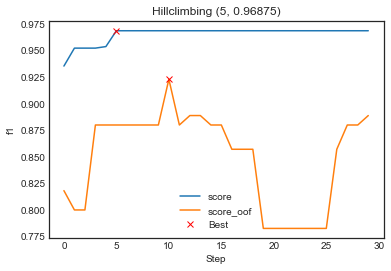

    step  midx     score  score_oof                mod      f1_0
0      0     1  0.935484   0.818182           airx_m67  0.935484
1      1     9  0.952381   0.800000  dpn68_gwap_ch_030  0.800000
2      2     2  0.952381   0.800000           cbam_m67  0.885246
3      3     1  0.952381   0.880000           airx_m67  0.935484
4      4     0  0.953846   0.880000            air_m68  0.843750
5      5     1  0.968750   0.880000           airx_m67  0.935484
6      6     1  0.968750   0.880000           airx_m67  0.935484
7      7     1  0.968750   0.880000           airx_m67  0.935484
8      8     1  0.968750   0.880000           airx_m67  0.935484
9      9     2  0.968750   0.880000           cbam_m67  0.885246
10    10     0  0.968750   0.923077            air_m68  0.843750

      weight                mod      f1_0
midx                                     
0          2            air_m68  0.843750
1          6           airx_m67  0.935484
2          2           cbam_m67  0.885246
9        

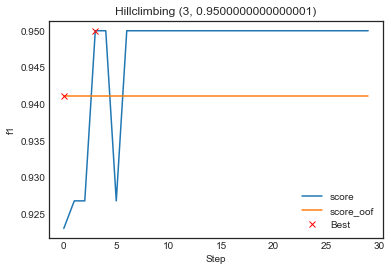

   step  midx     score  score_oof      mod      f1_0
0     0     0  0.923077   0.941176  air_m68  0.923077

      weight      mod      f1_0
midx                           
0          1  air_m68  0.923077


hillclimbing f1 fold 0 class 11 Intermediate filaments

model 0 f1 0.6649 0.935 0.7382 0.923 air_m68
model 1 f1 0.6744 0.935 0.7326 0.828 airx_m67
model 2 f1 0.6550 0.896 0.7070 0.899 cbam_m67
model 3 f1 0.6775 0.902 0.7194 0.847 preresnet_m67
model 4 f1 0.6861 0.294 0.7465 0.382 airnet50_gwap_ch_018
model 5 f1 0.6784 0.366 0.7433 0.241 airnet50_gwap_ch_028
model 6 f1 0.6991 0.273 0.7504 0.428 airnext50_gwap_ch_018
model 7 f1 0.6906 0.513 0.7433 0.606 airnext50_gwap_ch_030
model 8 f1 0.6579 0.447 0.7581 0.412 bn_inception_wgap_ch_042
model 9 f1 0.6813 0.297 0.7754 0.496 dpn68_gwap_ch_030
model 10 f1 0.6798 0.398 0.7430 0.512 resnet34_gwap_ch_042
model 11 f1 0.6739 0.430 0.7412 0.546 se_resnext50_gwap_ch_030
step = 0   index = 6   name = airnext50_gwap_ch_018    f1 = 0.6991  oof = 0.

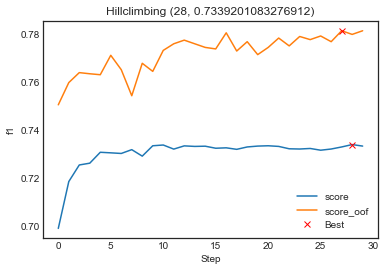

    step  midx     score  score_oof                       mod      f1_0
0      0     6  0.699055   0.750449     airnext50_gwap_ch_018  0.699055
1      1     3  0.718539   0.759690             preresnet_m67  0.677482
2      2     1  0.725437   0.763838                  airx_m67  0.674387
3      3     6  0.726183   0.763359     airnext50_gwap_ch_018  0.699055
4      4     3  0.730717   0.762963             preresnet_m67  0.677482
5      5     4  0.730482   0.771037      airnet50_gwap_ch_018  0.686062
6      6     3  0.730223   0.765049             preresnet_m67  0.677482
7      7     3  0.731806   0.754221             preresnet_m67  0.677482
8      8     4  0.729111   0.767717      airnet50_gwap_ch_018  0.686062
9      9     1  0.733424   0.764356                  airx_m67  0.674387
10    10     9  0.733736   0.773077         dpn68_gwap_ch_030  0.681289
11    11     0  0.732035   0.775828                   air_m68  0.664897
12    12    10  0.733378   0.777344      resnet34_gwap_ch_042  0

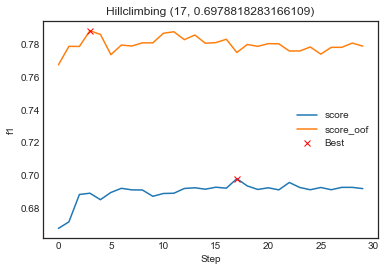

   step  midx     score  score_oof                    mod      f1_0
0     0     5  0.667413   0.767624   airnet50_gwap_ch_028  0.667413
1     1     1  0.671429   0.778947               airx_m67  0.604082
2     2     6  0.688196   0.778894  airnext50_gwap_ch_018  0.651014
3     3     9  0.688985   0.788512      dpn68_gwap_ch_030  0.641686

      weight                    mod      f1_0
midx                                         
1          1               airx_m67  0.604082
5          1   airnet50_gwap_ch_028  0.667413
6          1  airnext50_gwap_ch_018  0.651014
9          1      dpn68_gwap_ch_030  0.641686


hillclimbing f1 fold 0 class 13 Focal adhesion sites

model 0 f1 0.6364 0.951 0.7413 0.902 air_m68
model 1 f1 0.6322 0.915 0.6553 0.876 airx_m67
model 2 f1 0.5978 0.951 0.5854 0.759 cbam_m67
model 3 f1 0.6029 0.901 0.6755 0.875 preresnet_m67
model 4 f1 0.5863 0.234 0.6429 0.232 airnet50_gwap_ch_018
model 5 f1 0.6096 0.621 0.6393 0.521 airnet50_gwap_ch_028
model 6 f1 0.6291 0.249

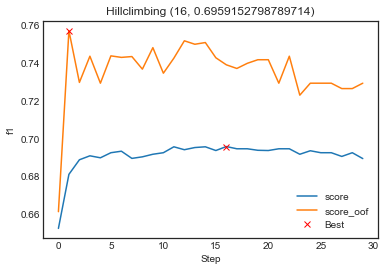

   step  midx     score  score_oof                    mod      f1_0
0     0     7  0.652632   0.661479  airnext50_gwap_ch_030  0.652632
1     1     0  0.681223   0.757143                air_m68  0.636364

      weight                    mod      f1_0
midx                                         
0          1                air_m68  0.636364
7          1  airnext50_gwap_ch_030  0.652632


hillclimbing f1 fold 0 class 14 Microtubules

model 0 f1 0.8269 0.901 0.8545 0.935 air_m68
model 1 f1 0.8283 0.855 0.8622 0.854 airx_m67
model 2 f1 0.8189 0.944 0.8459 0.921 cbam_m67
model 3 f1 0.8167 0.845 0.8321 0.929 preresnet_m67
model 4 f1 0.8411 0.384 0.8717 0.306 airnet50_gwap_ch_018
model 5 f1 0.8450 0.616 0.8671 0.391 airnet50_gwap_ch_028
model 6 f1 0.8345 0.453 0.8612 0.501 airnext50_gwap_ch_018
model 7 f1 0.8326 0.588 0.8522 0.635 airnext50_gwap_ch_030
model 8 f1 0.8380 0.410 0.8614 0.523 bn_inception_wgap_ch_042
model 9 f1 0.8390 0.424 0.8625 0.368 dpn68_gwap_ch_030
model 10 f1 0.8350 0.481

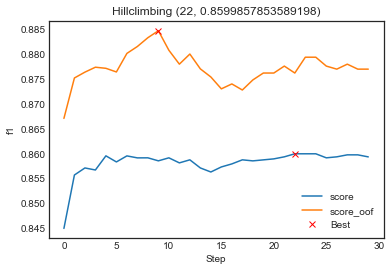

   step  midx     score  score_oof                       mod      f1_0
0     0     5  0.845011   0.867089      airnet50_gwap_ch_028  0.845011
1     1     2  0.855728   0.875197                  cbam_m67  0.818908
2     2     2  0.857143   0.876369                  cbam_m67  0.818908
3     3     0  0.856736   0.877358                   air_m68  0.826897
4     4     9  0.859574   0.877138         dpn68_gwap_ch_030  0.839031
5     5    11  0.858351   0.876404  se_resnext50_gwap_ch_030  0.831858
6     6     2  0.859562   0.880126                  cbam_m67  0.818908
7     7     2  0.859165   0.881517                  cbam_m67  0.818908
8     8     1  0.859175   0.883281                  airx_m67  0.828323
9     9     0  0.858571   0.884676                   air_m68  0.826897

      weight                       mod      f1_0
midx                                            
0          2                   air_m68  0.826897
1          1                  airx_m67  0.828323
2          4          

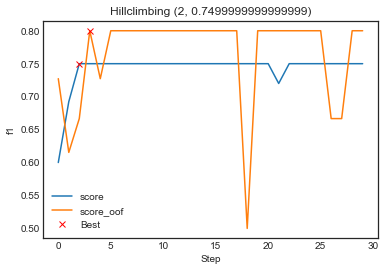

   step  midx     score  score_oof            mod      f1_0
0     0     3  0.600000   0.727273  preresnet_m67  0.600000
1     1     1  0.692308   0.615385       airx_m67  0.571429
2     2     2  0.750000   0.666667       cbam_m67  0.444444
3     3     3  0.750000   0.800000  preresnet_m67  0.600000

      weight            mod      f1_0
midx                                 
1          1       airx_m67  0.571429
2          1       cbam_m67  0.444444
3          2  preresnet_m67  0.600000


hillclimbing f1 fold 0 class 16 Cytokinetic bridge

model 0 f1 0.3445 0.929 0.2705 0.870 air_m68
model 1 f1 0.3765 0.797 0.2692 0.847 airx_m67
model 2 f1 0.3617 0.883 0.2030 0.935 cbam_m67
model 3 f1 0.3189 0.939 0.2636 0.901 preresnet_m67
model 4 f1 0.3079 0.267 0.3716 0.194 airnet50_gwap_ch_018
model 5 f1 0.3524 0.367 0.3755 0.148 airnet50_gwap_ch_028
model 6 f1 0.3752 0.384 0.3636 0.363 airnext50_gwap_ch_018
model 7 f1 0.3912 0.262 0.3618 0.202 airnext50_gwap_ch_030
model 8 f1 0.3213 0.307 0.3299 0.

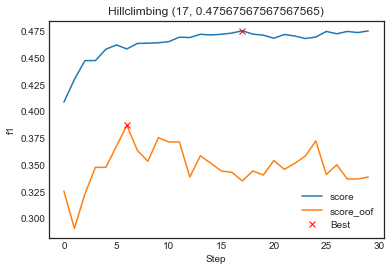

   step  midx     score  score_oof                       mod      f1_0
0     0    11  0.408824   0.325581  se_resnext50_gwap_ch_030  0.408824
1     1     2  0.430177   0.290698                  cbam_m67  0.361746
2     2     7  0.447717   0.322981     airnext50_gwap_ch_030  0.391245
3     3     1  0.447761   0.347826                  airx_m67  0.376523
4     4     0  0.458390   0.347826                   air_m68  0.344538
5     5    10  0.462396   0.367568      resnet34_gwap_ch_042  0.320755
6     6     9  0.458636   0.387097         dpn68_gwap_ch_030  0.375918

      weight                       mod      f1_0
midx                                            
0          1                   air_m68  0.344538
1          1                  airx_m67  0.376523
2          1                  cbam_m67  0.361746
7          1     airnext50_gwap_ch_030  0.391245
9          1         dpn68_gwap_ch_030  0.375918
10         1      resnet34_gwap_ch_042  0.320755
11         1  se_resnext50_gwap_ch_030 

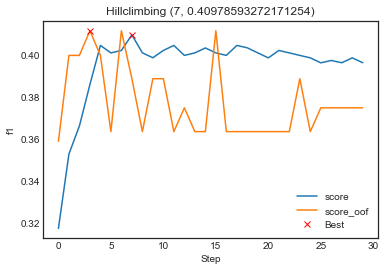

   step  midx     score  score_oof                   mod      f1_0
0     0     9  0.317460   0.358974     dpn68_gwap_ch_030  0.317460
1     1     2  0.352941   0.400000              cbam_m67  0.261209
2     2     4  0.366337   0.400000  airnet50_gwap_ch_018  0.257053
3     3     1  0.386076   0.411765              airx_m67  0.263254

      weight                   mod      f1_0
midx                                        
1          1              airx_m67  0.263254
2          1              cbam_m67  0.261209
4          1  airnet50_gwap_ch_018  0.257053
9          1     dpn68_gwap_ch_030  0.317460


hillclimbing f1 fold 0 class 18 Microtubule organizing center

model 0 f1 0.3801 0.855 0.2177 0.691 air_m68
model 1 f1 0.3787 0.758 0.2801 0.688 airx_m67
model 2 f1 0.3454 0.696 0.2122 0.713 cbam_m67
model 3 f1 0.3521 0.794 0.2451 0.646 preresnet_m67
model 4 f1 0.4170 0.261 0.2840 0.153 airnet50_gwap_ch_018
model 5 f1 0.4356 0.362 0.2553 0.202 airnet50_gwap_ch_028
model 6 f1 0.4055 0.196 0

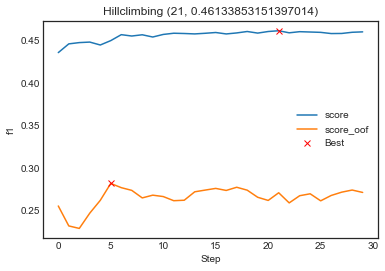

   step  midx     score  score_oof                    mod      f1_0
0     0     5  0.435630   0.255319   airnet50_gwap_ch_028  0.435630
1     1    10  0.445902   0.231884   resnet34_gwap_ch_042  0.416817
2     2    10  0.447402   0.228956   resnet34_gwap_ch_042  0.416817
3     3     6  0.448010   0.246914  airnext50_gwap_ch_018  0.405544
4     4     4  0.444585   0.261954   airnet50_gwap_ch_018  0.416974
5     5     1  0.449742   0.281834               airx_m67  0.378738

      weight                    mod      f1_0
midx                                         
1          1               airx_m67  0.378738
4          1   airnet50_gwap_ch_018  0.416974
5          1   airnet50_gwap_ch_028  0.435630
6          1  airnext50_gwap_ch_018  0.405544
10         2   resnet34_gwap_ch_042  0.416817


hillclimbing f1 fold 0 class 19 Centrosome

model 0 f1 0.4780 0.867 0.3943 0.669 air_m68
model 1 f1 0.4724 0.865 0.5331 0.706 airx_m67
model 2 f1 0.4267 0.752 0.4134 0.616 cbam_m67
model 3 f1 0.4381 

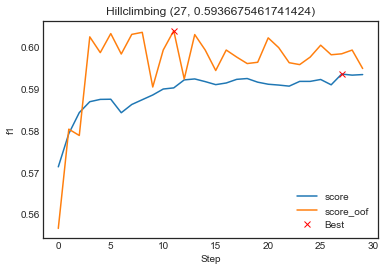

    step  midx     score  score_oof                       mod      f1_0
0      0     9  0.571429   0.556671         dpn68_gwap_ch_030  0.571429
1      1     4  0.579382   0.580460      airnet50_gwap_ch_018  0.569068
2      2     5  0.584427   0.578947      airnet50_gwap_ch_028  0.554420
3      3     8  0.587039   0.602582  bn_inception_wgap_ch_042  0.550397
4      4    11  0.587594   0.598802  se_resnext50_gwap_ch_030  0.553093
5      5     9  0.587633   0.603369         dpn68_gwap_ch_030  0.571429
6      6     4  0.584398   0.598473      airnet50_gwap_ch_018  0.569068
7      7    10  0.586374   0.603175      resnet34_gwap_ch_042  0.550516
8      8     6  0.587516   0.603667     airnext50_gwap_ch_018  0.554615
9      9     5  0.588649   0.590563      airnet50_gwap_ch_028  0.554420
10    10    11  0.590078   0.599432  se_resnext50_gwap_ch_030  0.553093
11    11    10  0.590351   0.604046      resnet34_gwap_ch_042  0.550516

      weight                       mod      f1_0
midx          

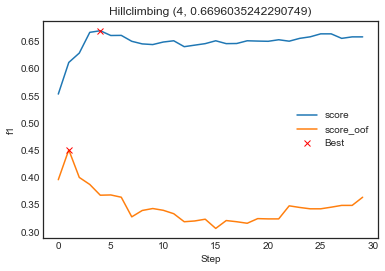

   step  midx     score  score_oof       mod      f1_0
0     0     1  0.553191   0.395833  airx_m67  0.553191
1     1     0  0.611354   0.450704   air_m68  0.550847

      weight       mod      f1_0
midx                            
0          1   air_m68  0.550847
1          1  airx_m67  0.553191


hillclimbing f1 fold 0 class 21 Plasma membrane

model 0 f1 0.5631 0.767 0.6116 0.598 air_m68
model 1 f1 0.5704 0.774 0.6491 0.741 airx_m67
model 2 f1 0.5530 0.764 0.5697 0.622 cbam_m67
model 3 f1 0.5825 0.792 0.6154 0.755 preresnet_m67
model 4 f1 0.6027 0.384 0.6630 0.236 airnet50_gwap_ch_018
model 5 f1 0.5853 0.339 0.6279 0.241 airnet50_gwap_ch_028
model 6 f1 0.5964 0.385 0.6453 0.153 airnext50_gwap_ch_018
model 7 f1 0.6021 0.298 0.6494 0.238 airnext50_gwap_ch_030
model 8 f1 0.5907 0.294 0.6508 0.222 bn_inception_wgap_ch_042
model 9 f1 0.6107 0.384 0.6544 0.182 dpn68_gwap_ch_030
model 10 f1 0.5891 0.439 0.6370 0.393 resnet34_gwap_ch_042
model 11 f1 0.6002 0.443 0.6159 0.363 se_resnext50_gw

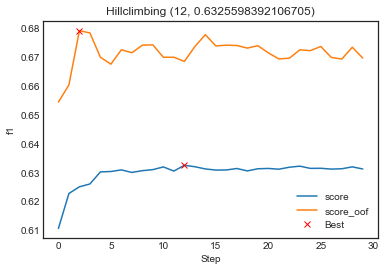

   step  midx     score  score_oof                   mod      f1_0
0     0     9  0.610720   0.654424     dpn68_gwap_ch_030  0.610720
1     1     3  0.622805   0.660354         preresnet_m67  0.582457
2     2     4  0.625116   0.679095  airnet50_gwap_ch_018  0.602714

      weight                   mod      f1_0
midx                                        
3          1         preresnet_m67  0.582457
4          1  airnet50_gwap_ch_018  0.602714
9          1     dpn68_gwap_ch_030  0.610720


hillclimbing f1 fold 0 class 22 Cell junctions

model 0 f1 0.5060 0.856 0.5418 0.899 air_m68
model 1 f1 0.5331 0.896 0.5290 0.838 airx_m67
model 2 f1 0.4526 0.835 0.4625 0.801 cbam_m67
model 3 f1 0.5137 0.867 0.4384 0.847 preresnet_m67
model 4 f1 0.5570 0.251 0.5223 0.233 airnet50_gwap_ch_018
model 5 f1 0.5482 0.241 0.5817 0.311 airnet50_gwap_ch_028
model 6 f1 0.5591 0.263 0.5324 0.289 airnext50_gwap_ch_018
model 7 f1 0.5599 0.271 0.5161 0.304 airnext50_gwap_ch_030
model 8 f1 0.5092 0.306 0.5256 0.2

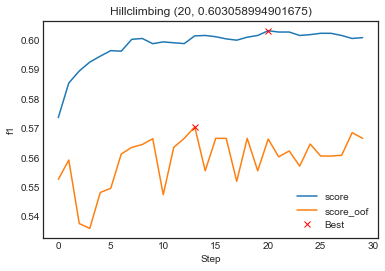

    step  midx     score  score_oof                       mod      f1_0
0      0    11  0.573608   0.552632  se_resnext50_gwap_ch_030  0.573608
1      1     9  0.585330   0.559211         dpn68_gwap_ch_030  0.565611
2      2     7  0.589409   0.537634     airnext50_gwap_ch_030  0.559938
3      3     6  0.592424   0.536000     airnext50_gwap_ch_018  0.559055
4      4    11  0.594432   0.548193  se_resnext50_gwap_ch_030  0.573608
5      5    11  0.596310   0.549618  se_resnext50_gwap_ch_030  0.573608
6      6     0  0.596125   0.561265                   air_m68  0.506041
7      7    11  0.600146   0.563492  se_resnext50_gwap_ch_030  0.573608
8      8    11  0.600438   0.564460  se_resnext50_gwap_ch_030  0.573608
9      9    11  0.598670   0.566434  se_resnext50_gwap_ch_030  0.573608
10    10     4  0.599273   0.547445      airnet50_gwap_ch_018  0.557001
11    11    11  0.598985   0.563492  se_resnext50_gwap_ch_030  0.573608
12    12     0  0.598698   0.566553                   air_m68  0

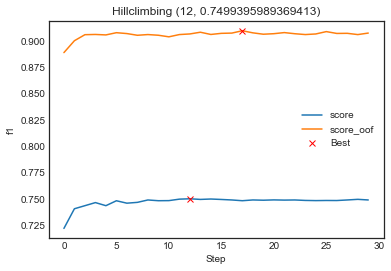

    step  midx     score  score_oof                       mod      f1_0
0      0     6  0.721758   0.888889     airnext50_gwap_ch_018  0.721758
1      1     0  0.740454   0.900193                   air_m68  0.712093
2      2     9  0.743371   0.905928         dpn68_gwap_ch_030  0.709946
3      3     1  0.746305   0.906149                  airx_m67  0.700023
4      4     9  0.743371   0.905709         dpn68_gwap_ch_030  0.709946
5      5     3  0.748054   0.907819             preresnet_m67  0.717875
6      6     3  0.745746   0.906992             preresnet_m67  0.717875
7      7     2  0.746526   0.905371                  cbam_m67  0.702690
8      8    10  0.748802   0.906049      resnet34_gwap_ch_042  0.717912
9      9     6  0.748095   0.905397     airnext50_gwap_ch_018  0.721758
10    10     9  0.748188   0.903896         dpn68_gwap_ch_030  0.709946
11    11     4  0.749577   0.906049      airnet50_gwap_ch_018  0.707168
12    12    10  0.749940   0.906632      resnet34_gwap_ch_042  0

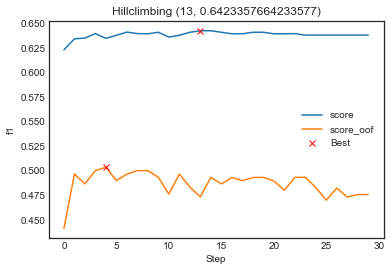

   step  midx     score  score_oof                       mod      f1_0
0     0     6  0.622871   0.441176     airnext50_gwap_ch_018  0.622871
1     1    11  0.634146   0.496552  se_resnext50_gwap_ch_030  0.588506
2     2     7  0.634845   0.486486     airnext50_gwap_ch_030  0.607539
3     3    11  0.639423   0.500000  se_resnext50_gwap_ch_030  0.588506
4     4    11  0.634615   0.503497  se_resnext50_gwap_ch_030  0.588506

      weight                       mod      f1_0
midx                                            
6          1     airnext50_gwap_ch_018  0.622871
7          1     airnext50_gwap_ch_030  0.607539
11         3  se_resnext50_gwap_ch_030  0.588506


hillclimbing f1 fold 0 class 25 Cytosol

model 0 f1 0.6375 0.712 0.6607 0.699 air_m68
model 1 f1 0.6412 0.744 0.6396 0.759 airx_m67
model 2 f1 0.6268 0.758 0.6556 0.703 cbam_m67
model 3 f1 0.6307 0.746 0.6426 0.778 preresnet_m67
model 4 f1 0.6135 0.241 0.6525 0.242 airnet50_gwap_ch_018
model 5 f1 0.6051 0.251 0.6492 0.228 ai

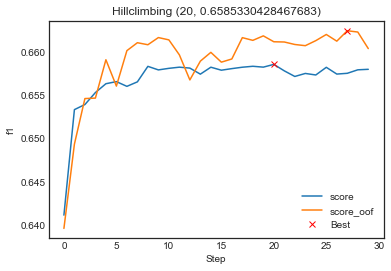

    step  midx     score  score_oof                       mod      f1_0
0      0     1  0.641164   0.639634                  airx_m67  0.641164
1      1     9  0.653321   0.649346         dpn68_gwap_ch_030  0.625314
2      2     3  0.653908   0.654597             preresnet_m67  0.630724
3      3     1  0.655288   0.654649                  airx_m67  0.641164
4      4     6  0.656305   0.659069     airnext50_gwap_ch_018  0.629606
5      5     3  0.656548   0.656032             preresnet_m67  0.630724
6      6     2  0.656003   0.660116                  cbam_m67  0.626790
7      7     6  0.656521   0.661031     airnext50_gwap_ch_018  0.629606
8      8     1  0.658307   0.660798                  airx_m67  0.641164
9      9     9  0.657899   0.661624         dpn68_gwap_ch_030  0.625314
10    10     1  0.658079   0.661358                  airx_m67  0.641164
11    11     9  0.658213   0.659632         dpn68_gwap_ch_030  0.625314
12    12    11  0.658106   0.656745  se_resnext50_gwap_ch_030  0

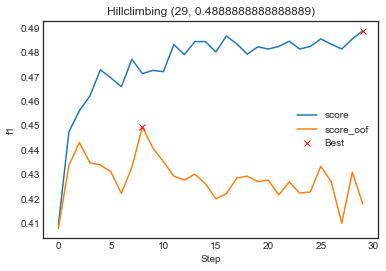

   step  midx     score  score_oof                       mod      f1_0
0     0     1  0.409357   0.407895                  airx_m67  0.409357
1     1     5  0.447471   0.433735      airnet50_gwap_ch_028  0.358318
2     2     0  0.456140   0.443114                   air_m68  0.354386
3     3     1  0.462168   0.434783                  airx_m67  0.409357
4     4     8  0.472885   0.433862  bn_inception_wgap_ch_042  0.312715
5     5     0  0.469565   0.431138                   air_m68  0.354386
6     6     1  0.465934   0.422222                  airx_m67  0.409357
7     7     4  0.477223   0.432990      airnet50_gwap_ch_018  0.345455
8     8     2  0.471338   0.449438                  cbam_m67  0.355932

      weight                       mod      f1_0
midx                                            
0          2                   air_m68  0.354386
1          3                  airx_m67  0.409357
2          1                  cbam_m67  0.355932
4          1      airnet50_gwap_ch_018  0.34

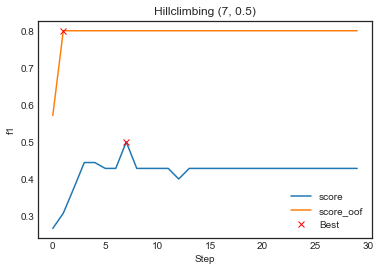

   step  midx     score  score_oof                   mod      f1_0
0     0     2  0.266667   0.571429              cbam_m67  0.266667
1     1    10  0.307692   0.800000  resnet34_gwap_ch_042  0.181818

      weight                   mod      f1_0
midx                                        
2          1              cbam_m67  0.266667
10         1  resnet34_gwap_ch_042  0.181818

overall mean f1 0.6977275891293233  mean cut 0.4860430831263403   mean steps 16.678571428571427


<Figure size 432x288 with 0 Axes>

In [71]:
# oof = small

# hillclimbing
# vp = oof.copy()
# offset = 5
# nm = vp.shape[1] - offset
nr = vp.shape[0]
y = np.array([y for y in vp.y])
# y = np.array(list(vp['masks'].values))

yt = y[folds != fold]
yf = y[folds == fold]

nstep = 30

step0fix = -1
# step0fix = 5
step1fix = -1

intercept = 0
metric = 'f1'
# metric = 'iou'

# threshold = 0.
# threshold = 0.36
threshold = 0.49
# threshold = 0.5
# print('using ' + metric + ' threshold',threshold)
# print('optimizing ' + metric + ' by hillclimbing on fold ' + str(fold))

# metric = "mcc"
# metric = "corr"
# metric = "rmse"
# metric = "mse"
# metric = "mae"
# metric = "winsorized_mae"
# metric = "auc"

cut_mets = ['mcc','f1']

num_classes = 28
th = np.zeros(num_classes)
threshold_best = threshold


rez_all = []
tb_all = []

bestEnsemble_all = []
bestStep_all = []
bestScore_all = []
bestCut_all = []

bestEnsemble_oof_all = []
bestStep_oof_all = []
bestScore_oof_all = []
bestCut_oof_all = []

for c in range(num_classes):
    
    print()
    print()
    print('hillclimbing',metric,'fold',fold,'class',c,LABEL_MAP[c])
    print()

    rez = pd.DataFrame({'step':np.zeros(nstep).astype(int),'midx':np.zeros(nstep).astype(int),
                        'score':np.zeros(nstep),'score_oof':np.zeros(nstep)})
    currEnsemble = 0 * np.array(list(vp.iloc[:,offset].values))

    # maximizing
    bestScore = -9999999
    bestScore_oof = -9999999
    single = pd.DataFrame({'mod':np.repeat("",nm)})
    start = 0
    for step in range(start,nstep):
        single[metric+'_'+str(step)] = np.nan

    single_oof = single.copy()

    for step in range(start,nstep):
        currIndex = 0
        currScore = -9999999
        currScore_oof = -9999999

        for i in range(nm):

            mn = vp.columns[i+offset]

            tv = np.array(list(vp.iloc[:,offset+i].values))

            # mean-center
    #         tv = tv - np.mean(tv)

            # adjust by model-specific threshold
    #         tv = tv - mthresh[mn]

            # adjust by model-class-specific thresholds
    #         for j in range(tv.shape[1]):
    #             tv[:,j] = tv[:,j] - cthresh[mn][j]

            if np.sum(np.isnan(tv)) > 0: continue

            if step==0:
                tryEnsemble = tv
            else:
                # running mean
                tryEnsemble = (step * currEnsemble + tv)/(step+1)
                # full matrix
                # choose median or mean here
                # tryEnsemble = rowMedians(cbind(currEnsemble,tv))
                # tryEnsemble = rowMeans(cbind(currEnsemble,tv))
                # quantiles are a lot slower
                # tryEnsemble = rowQuantiles(cbind(currEnsemble,tv),probs=0.6)

            if metric=="f1":
    #             # estimate new class-specific thresholds by least squares, very slow
    #             th = fit_val(tryEnsemble,y)
    #             th[th<0.1] = 0.1
    #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
    #                                 average='macro')

                # estimate new class-specific thresholds by line search, slow
                et = tryEnsemble[folds != fold]
                cutt = fit_val1(et[:,c],yt[:,c])
                tryScore = f1_score(yt[:,c], np.int32(et[:,c] > cutt))

                ef = tryEnsemble[folds == fold]
                cutf = fit_val1(ef[:,c],yf[:,c])
                tryScore_oof = f1_score(yf[:,c], np.int32(ef[:,c] > cutf))

    #             # estimate new class-specific thresholds to match proportions, medium
    #             for j in range(num_classes):
    #                 th[j] = fit_val2(tryEnsemble[:,j],y[:,j])
    #             tryScore = f1_score(y, np.int32(tryEnsemble > th),
    #                                 average='macro')

    #             # fixed threshold, fast
    #             tryScore = f1_score(y, np.int32(tryEnsemble > threshold),
    #                                 average='macro')

#                 if step > 0: print('    try',i,mn,"%6.4f" % tryScore,"%6.4f" % tryScore_oof)
            elif metric=="iou":
                tryScore = iou_metric_batch(y, np.int32(tryEnsemble > threshold),
                                            pred_eps=pred_eps)
                if step > 0: print('    try',i,mn,"%6.4f" % tryScore)
            elif metric=="mse":
                tryScore = -mse(y,tryEnsemble)
            elif metric=="mae": 
                tryScore = -mae(y,tryEnsemble)
            elif metric=="winsorized_mae": 
                tryScore = -winsorized_mae(y,tryEnsemble+intercept)
            elif metric=="rmse":
                tryScore = -rmse(y,tryEnsemble)
            elif metric=="corr":
                tryScore = cor(y,tryEnsemble)
            elif metric=="mcc":
                opt = eval_mcc3(y,tryEnsemble,cut=T)
                tryScore = opt[1]
                cut = opt[2]
                # opt = optimize(mcc,c(0.1,0.3),tryEnsemble,vp$y,maximum=T)
                # tryScore = opt$objective
            elif metric=="logloss":
                # tryScore = -logLoss(vp$y,tryEnsemble,)
                tryScore = -eval_logloss2(tryEnsemble,y)
            elif metric=="auc":
                tryScore = auc2(y,tryEnsemble)
            elif metric=="auprc":
                tryScore = auprc(tryEnsemble, y)
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                # tryScore = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.davis.goadrich
            elif metric=="aurocpr":
                auroc = auc(y,tryEnsemble)
                # auprc = pr.curve(scores.class0 = tryEnsemble, weights.class0 = vp$y)$auc.integral
                tryScore = (auroc + auprc)/2
            elif metric=="sqwk":
                tryScore = sqwk(y,tryEnsemble,1,8)

            ok = 1
            if (step==0) and (step0fix>-1) and (i!=step0fix): ok = 0 
            if (step==1) and (step1fix>-1) and (i!=step1fix): ok = 0 

            if (tryScore > currScore) and (ok==1):
                currIndex = i
                currScore = tryScore
                currScore_oof = tryScore_oof
                if (step==0):
                    saveEnsemble = tv.copy()
                else:
                    # running mean
                    saveEnsemble = tryEnsemble.copy()
                    # save whole matrix
                    # saveEnsemble = np.concatenate((currEnsemble,tv),axis=1)
                if metric in cut_mets: 
                    currCut = cutt
                    currCut_oof = cutf

            # if (step==0) or ((step==1) and (step0fix>-1)) or ((step==2) and (step1fix>-1)):
            if (step==0):
                if metric in cut_mets:
                    print("model",i,metric, "%6.4f %5.3f %6.4f %5.3f" % \
                          (tryScore,cutt,tryScore_oof,cutf), vp.columns[i+offset])
                else:
                    print("model",i,metric,"for",vp.columns[i+offset],"= %6.4f" % tryScore,
                         " oof = %6.4f" % tryScore_oof)

            if step==0:
                single.loc[i,'mod'] = vp.columns[i+offset]  
                single_oof.loc[i,'mod'] = vp.columns[i+offset]  
            single.iloc[i,step+1] = tryScore
            single_oof.iloc[i,step+1] = tryScore_oof

        currEnsemble = saveEnsemble.copy()
        if currScore > bestScore:
            bestScore = currScore
            bestStep = step
            bestEnsemble = currEnsemble.copy()
            if metric in cut_mets: 
                bestCut = currCut
                bestCut_oof = currCut_oof
        if currScore_oof > bestScore_oof:
            bestScore_oof = currScore_oof
            bestStep_oof = step
            bestEnsemble_oof = currEnsemble.copy()
            if metric in cut_mets: 
                bestCut = currCut
                bestCut_oof = currCut_oof
            star = '*'
        else:
            star = ' '

        if metric=="mcc":
            print("step =",step,"  index =",currIndex,"  name =", vp.columns[currIndex+offset],"  ",
                metric,"= %6.4f" % currScore,"  cut =",currCut)
        else:
            print(step," train %6.4f" % currScore,
                  " val %6.4f%s" % (currScore_oof,star),
                  " ",vp.columns[currIndex+offset])

        rez.iloc[step,0] = step
        rez.iloc[step,1] = currIndex
        rez.iloc[step,2] = currScore
        rez.iloc[step,3] = currScore_oof

    if (metric=="mcc"):
        print("best step =",bestStep,"  best",metric,"=",bestScore,"  best cut =",bestCut)
    else:
        print("best step =",bestStep,"  best",metric,"=",bestScore)
        print("best step oof =",bestStep_oof,"  best",metric,"=",bestScore_oof)

    rez0 = rez.copy()

    # tb = table(rez$index[1:bestStep])
    # names(tb) = names(vp)[(offset+1):ncol(vp)][as.integer(names(table(rez$index[1:bestStep])))]

    # if (intercept!=0) {
    #   tb["Intercept"] = intercept
    # }

    # print(tb[order(-tb)])
    # print(single[order(-single[,2]),][1:min(nrow(single),40),])

    # plot hillclimbing
    print('')
    plt.plot(rez0.step, rez0.score)
    plt.plot(rez0.step, rez0.score_oof)
    plt.plot(bestStep, bestScore, "xr", label="Best")
    plt.plot(bestStep_oof, bestScore_oof, "xr")
    plt.xlabel("Step")
    plt.ylabel(metric)
#     plt.title("Hillclimbing ({}, {})".format(bestStep, bestScore))
    plt.title("Hillclimbing Fold %d Class %d %s" % (fold,c,LABEL_MAP[c]))
    plt.legend()
    plt.show()
    plt.gcf().clear()
    
    # display the weights
    rez = rez.iloc[:(bestStep_oof+1)]
    # print(rez)

    single0 = single.iloc[:,:2]

    rez['midx'] = rez['midx'].astype(int)
    rez = rez.join(single0,how='left',on='midx')
    print(rez)
    print('')

    rez['weight'] = 1
    tb = rez.loc[:,['midx','weight']].groupby('midx').count()
    # print(tb)
    # print(single)

    tb = tb.join(single0,how='left')
    print(tb)
    
    rez_all.append(rez)
    tb_all.append(tb)
    bestEnsemble_all.append(bestEnsemble)
    bestStep_all.append(bestStep)
    bestScore_all.append(bestScore)
    bestCut_all.append(bestCut)
    bestEnsemble_oof_all.append(bestEnsemble_oof)
    bestStep_oof_all.append(bestStep_oof)
    bestScore_oof_all.append(bestScore_oof)
    bestCut_oof_all.append(bestCut_oof)

print()
print('overall mean f1',np.mean(bestScore_all),' mean cut',np.mean(bestCut_all),
      '  mean steps',np.mean(bestStep_all))  

print('mean f1',np.mean(bestScore_oof_all),' mean cut',np.mean(bestCut_oof_all),
      '  mean steps',np.mean(bestStep_oof_all))

In [ ]:
print('mean f1',np.mean(bestScore_oof_all),' mean cut',np.mean(bestCut_oof_all),
      '  mean steps',np.mean(bestStep_oof_all))

In [73]:
# tb_all

In [74]:
# save weights and thresholds
print('')
os.makedirs('weights',exist_ok=True)
fname = 'weights/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(tb_all,open(fname,'wb'))
print(fname)

print('')
os.makedirs('thresholds',exist_ok=True)
fname = 'thresholds/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(bestCut_all,open(fname,'wb'))
print(fname)


weights/hill_m94_0.pkl

thresholds/hill_m94_0.pkl


In [75]:
for i in range(28):
    tb_all[i]['class'] = i
tba = pd.concat(tb_all).reset_index()
print(tba.shape)

(145, 5)


In [76]:
tba.head()

midx  weight                    mod      f1_0  class
0     0       3                air_m68  0.831174      0
1     1       5               airx_m67  0.833735      0
2     2       6               cbam_m67  0.830502      0
3     3       3          preresnet_m67  0.826684      0
4     7       2  airnext50_gwap_ch_030  0.826647      0

In [77]:
# show most popular models
tbag = tba.groupby('mod')
ws = pd.DataFrame(tbag['weight'].sum())
ws.columns = ['ws']
ws.sort_values(['ws'],ascending=False,inplace=True)
print(ws)

                          ws
mod                         
airx_m67                  41
cbam_m67                  29
airnext50_gwap_ch_018     27
dpn68_gwap_ch_030         26
air_m68                   25
airnet50_gwap_ch_018      25
preresnet_m67             24
se_resnext50_gwap_ch_030  23
airnet50_gwap_ch_028      18
resnet34_gwap_ch_042      17
airnext50_gwap_ch_030     14
bn_inception_wgap_ch_042  11


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


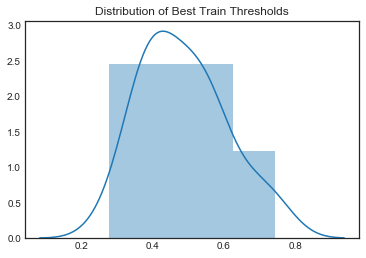

/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


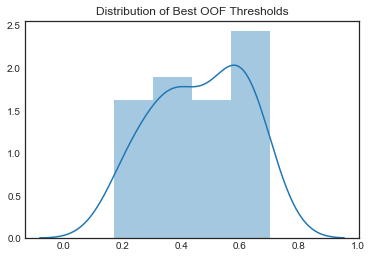

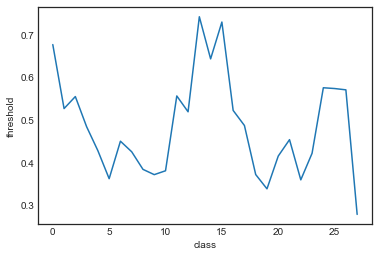

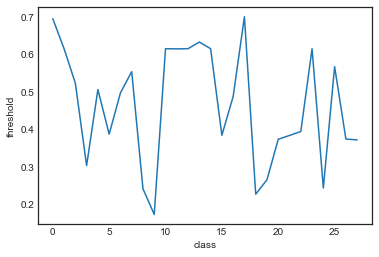

<Figure size 432x288 with 0 Axes>

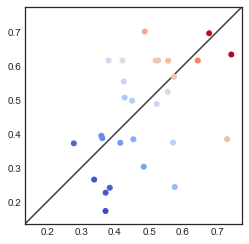

0 0.6769320775593947 0.695820884003125
1 0.5269018676745961 0.615679528216301
2 0.5550631713662069 0.5236255351922381
3 0.4843684387216952 0.303283968039926
4 0.42811133997419787 0.5066202580799939
5 0.3624654175223114 0.3872967690653767
6 0.45037238050105616 0.4974802840467854
7 0.42557072909433974 0.5542338234524024
8 0.38433224574175506 0.24135260693421914
9 0.3719700378516344 0.17285034952472136
10 0.381044954663125 0.6156776133205051
11 0.556472929727529 0.6152092819595806
12 0.5193255311800491 0.6156792388520937
13 0.7421895654242993 0.6334226322358993
14 0.6434195474691891 0.6156790726310191
15 0.729757961290251 0.3843305672962681
16 0.5225353614518763 0.48805928612636484
17 0.4871802949005077 0.7010542226421795
18 0.3721954094967576 0.2268673163231641
19 0.33866630665330394 0.265377458326617
20 0.41551995092775 0.37363946897235323
21 0.4539875424402283 0.383871783617436
22 0.35975311069412064 0.39432337080345253
23 0.4220217453740259 0.6156776490095565
24 0.5756796918646029 0.2

<Figure size 432x288 with 0 Axes>

In [89]:
sns.distplot(np.array(bestCut_all))
plt.title("Distribution of Best Train Thresholds")
plt.show()
plt.gcf().clear()

sns.distplot(np.array(bestCut_oof_all))
plt.title("Distribution of Best OOF Thresholds")
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestCut_all))
plt.xlabel("class")
plt.ylabel("threshold")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

plt.plot(range(num_classes), np.array(bestCut_oof_all))
plt.xlabel("class")
plt.ylabel("threshold")
# plt.title(LABEL_MAP[c] + " " + metric + " hillclimbing (%d, %6.4f)" % (bestStep, bestScore))
# plt.legend()
plt.show()
plt.gcf().clear()

c = np.array(bestCut_all)**2 + np.array(bestCut_oof_all)**2

fig, ax = plt.subplots()
ax.scatter( np.array(bestCut_all),  np.array(bestCut_oof_all), 
           s=25, c=c, cmap=plt.cm.coolwarm, zorder=10)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()
plt.gcf().clear()

for i in range(num_classes):
    print(i,bestCut_all[i],bestCut_oof_all[i])

In [79]:
bestEnsemble_all0 = bestEnsemble_oof.copy()

In [92]:
# save out-of-fold predictions
nf = np.sum(folds==fold)
print(nf)
ens = np.zeros((nf,num_classes))
for j in range(num_classes):
    ens[:,j] = bestEnsemble_oof_all[j][folds==fold,j]
     
oof_ids = oof.index.values[folds==fold]
poof = ens.copy()
yoof = y[folds==fold]

oof = [oof_ids, poof, yoof]
fname = 'oof/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(oof,open(fname,'wb'))
print(fname)
    
# p = pd.DataFrame(ens)
# p.columns = ['p'+str(i) for i in range(ens.shape[1])]
# yd = pd.DataFrame(y)
# yd.names = ['y'+str(i) for i in range(ens.shape[1])]
# subp = pd.DataFrame({'id':vp.index.values[folds==fold],'data':'oof'})
# subp = pd.concat((subp,yd,p),axis=1)
# print(subp.shape)
# fname = 'oof/' + mname + '_' + str(fold) + '.csv'
# subp.to_csv(fname, index=False)
# print(fname)

7558
oof/hill_m94_0.pkl


In [96]:
pred = ens.copy()
num_classes = x.shape[1]
print(pred.shape,pred.min(),pred.mean(),pred.max(),num_classes)
name_label_dict = LABEL_MAP
th = np.zeros(num_classes)
for i in range(num_classes):
    th[i] = fit_val1(pred[:,i],y[folds==fold,i])
# th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y[folds==fold], pred>th, average='macro'))
print('F1 micro: ',f1_score(y[folds==fold], pred>th, average='micro'))

(7558, 28) 6.361621529669967e-10 0.09744968343997841 0.9999307696640978 28
Thresholds:  [0.696 0.566 0.57  0.301 0.507 0.335 0.409 0.56  0.241 0.173 0.616 0.616 0.583 0.501 0.759 0.384 0.453 0.799 0.224 0.246 0.811 0.384 0.369 0.616 0.394 0.568 0.449 0.594]
F1 macro:  0.6975721419869332
F1 micro:  0.7415939499709133



f1_best 0.640152400360382
threshold_best 0.45



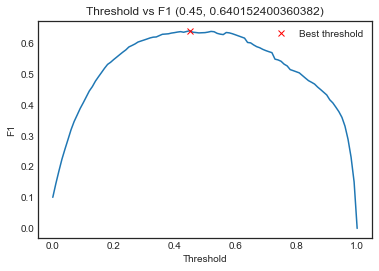

<Figure size 432x288 with 0 Axes>

In [94]:
# grid search for single best threshold
vlsp = pred.copy()

thresholds = np.linspace(0, 1., 101)
scores = np.array([f1_score(yoof, (vlsp > t).astype(int), average='macro') \
                 for t in thresholds])

threshold_best_index = np.argmax(scores)
score_best = scores[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print('')
print('f1_best',score_best)
print('threshold_best',threshold_best)
print('')

plt.plot(thresholds, scores)
plt.plot(threshold_best, score_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold vs F1 ({}, {})".format(threshold_best, score_best))
plt.legend()
plt.show()
plt.gcf().clear()

6.361621529669967e-10 0.09744968343997841 0.9999307696640978 (211624,)


/home/sasrdw/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


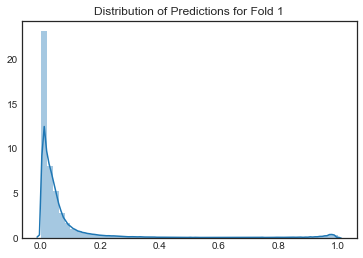

<Figure size 432x288 with 0 Axes>

In [97]:
vf = vlsp.flatten()
print(vf.min(),vf.mean(),vf.max(),vf.shape)
sns.distplot(vf)
plt.title("Distribution of Predictions for Fold " + str(fold+1))
plt.show()
plt.gcf().clear()

In [98]:
# num_rows = x.shape[0]
# c = np.zeros(num_rows)
# for i in range(num_rows):
#     c[i] = np.corrcoef(pred[i],yoof[i])[0,1]
# o = oof.iloc[:,:1]
# o['corr'] = c

# fname = 'corrs'+midx+'_'+str(fold)+'.csv'
# o.to_csv(fname)
# print(fname)

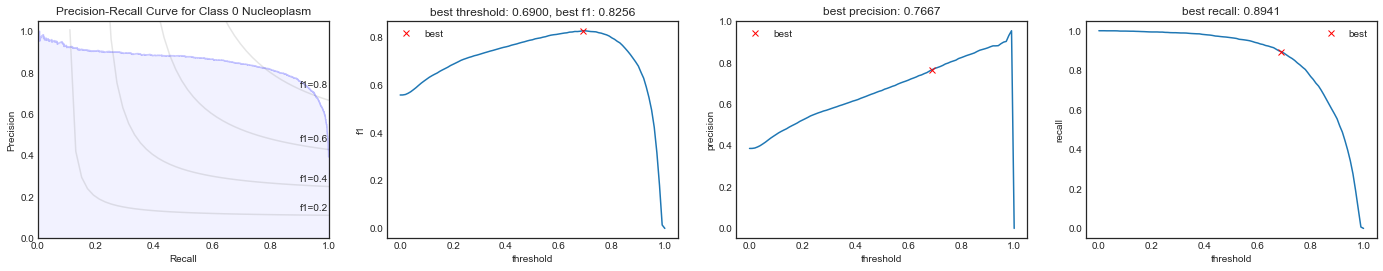

<Figure size 432x288 with 0 Axes>

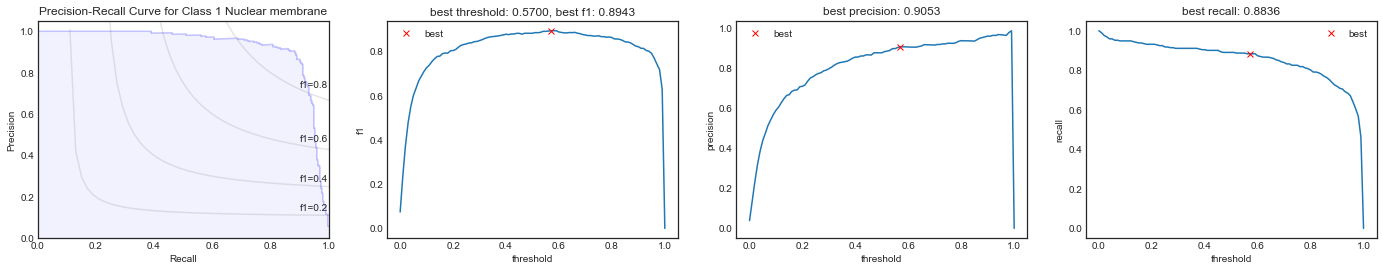

<Figure size 432x288 with 0 Axes>

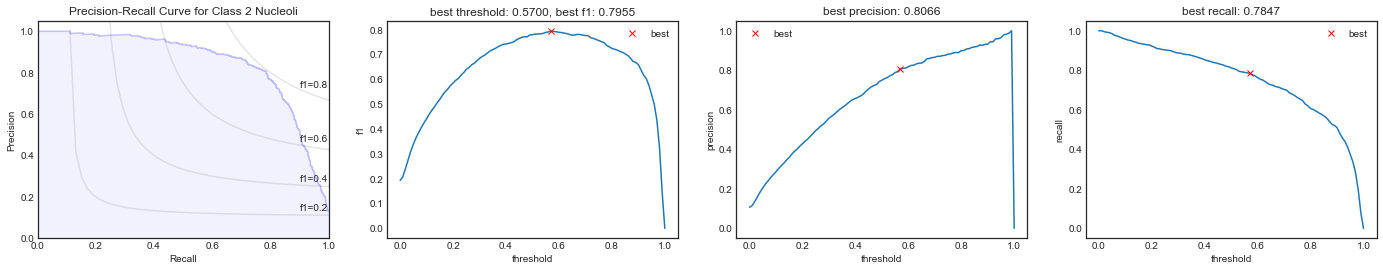

<Figure size 432x288 with 0 Axes>

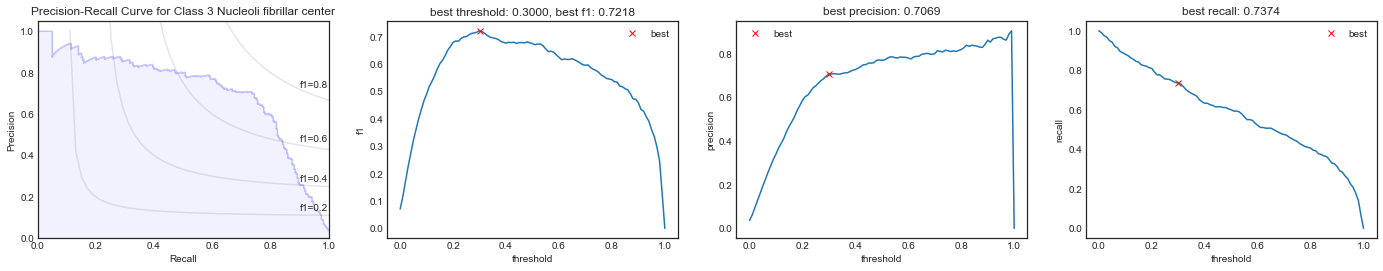

<Figure size 432x288 with 0 Axes>

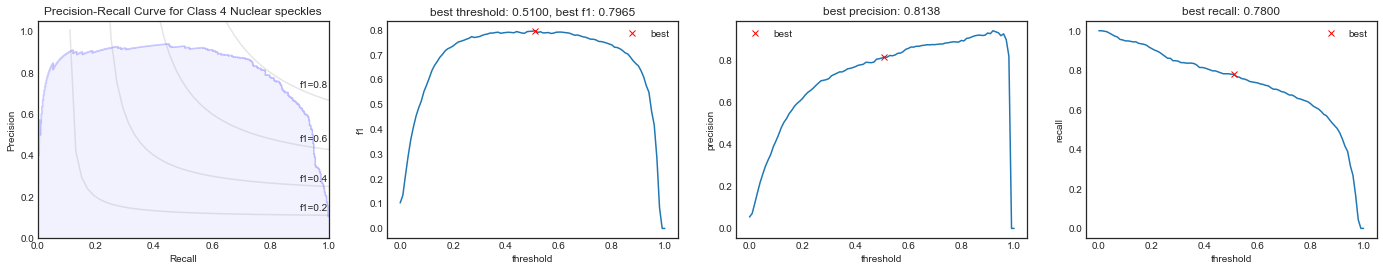

<Figure size 432x288 with 0 Axes>

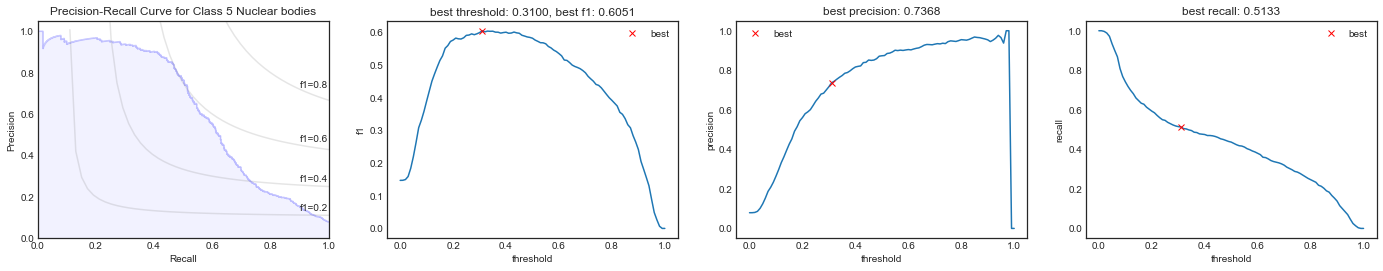

<Figure size 432x288 with 0 Axes>

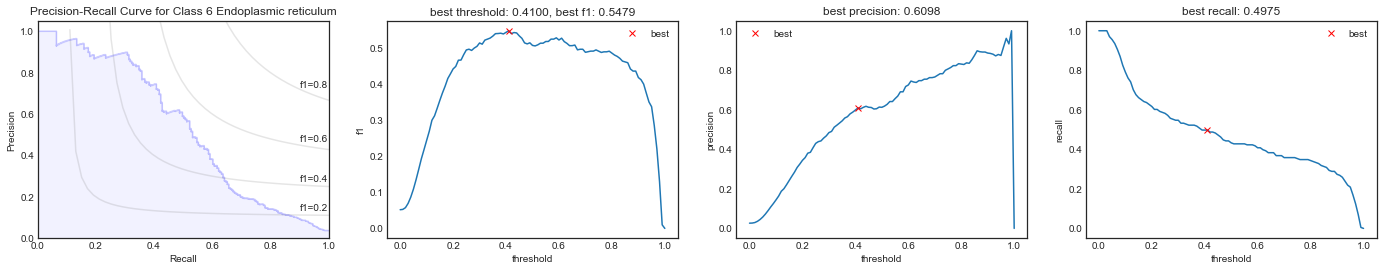

<Figure size 432x288 with 0 Axes>

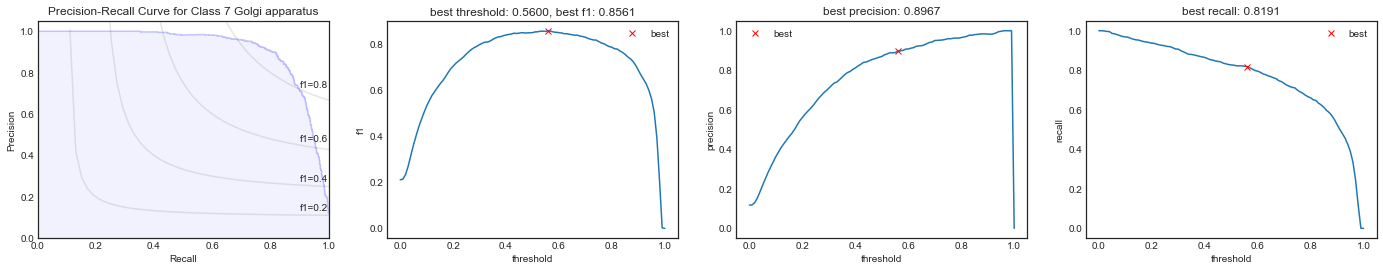

<Figure size 432x288 with 0 Axes>

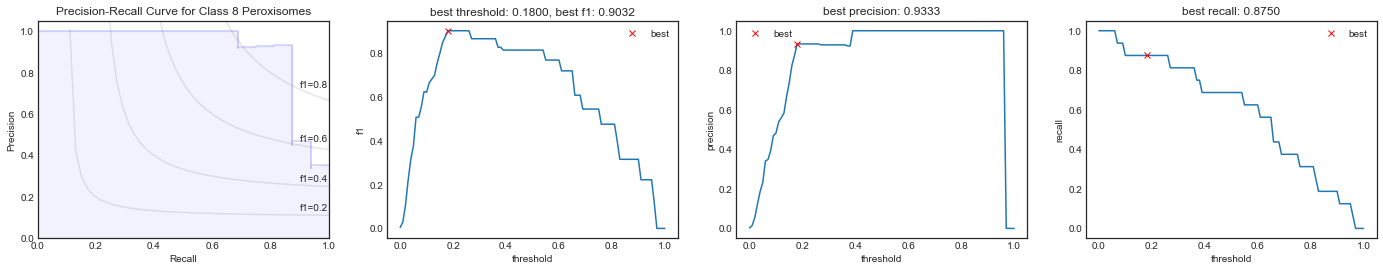

<Figure size 432x288 with 0 Axes>

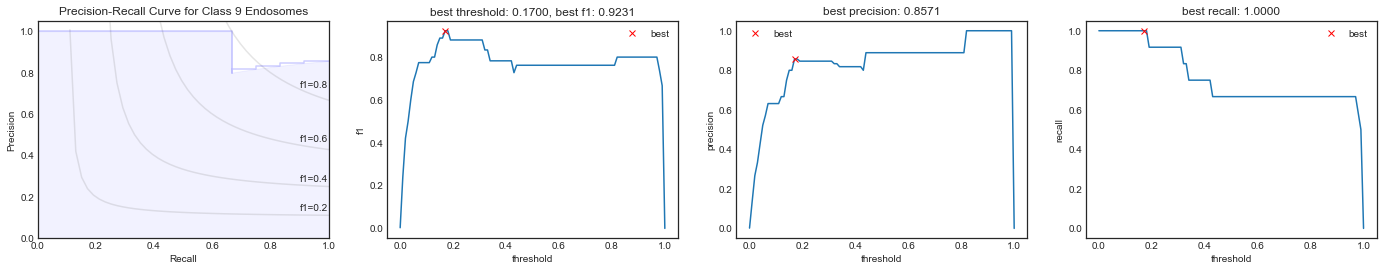

<Figure size 432x288 with 0 Axes>

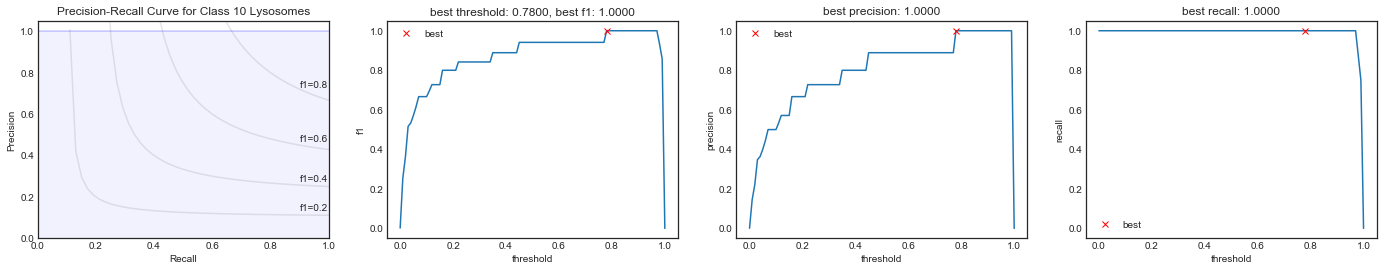

<Figure size 432x288 with 0 Axes>

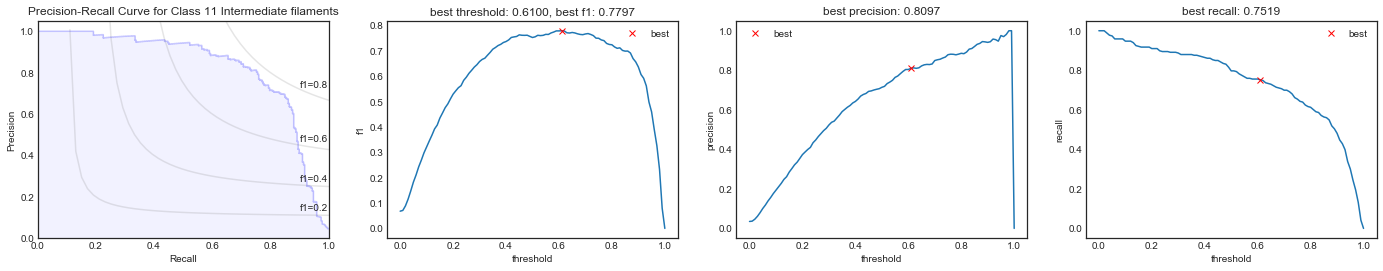

<Figure size 432x288 with 0 Axes>

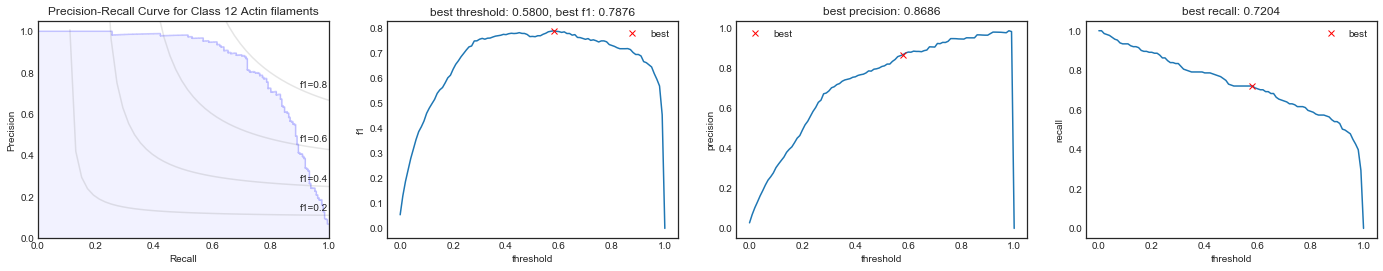

<Figure size 432x288 with 0 Axes>

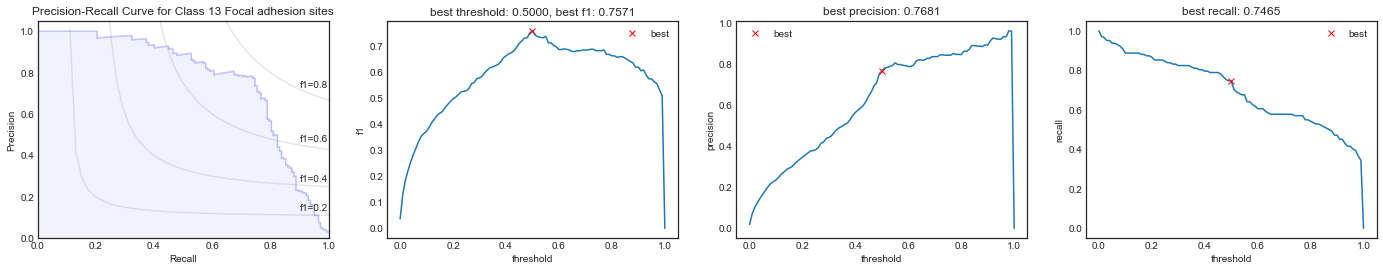

<Figure size 432x288 with 0 Axes>

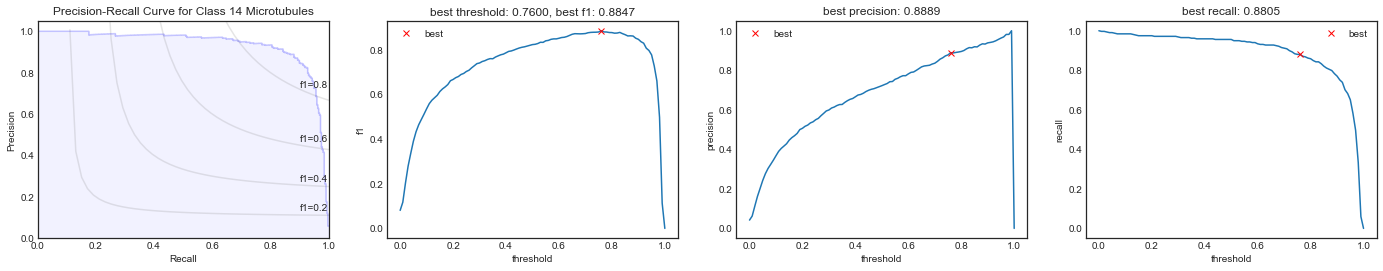

<Figure size 432x288 with 0 Axes>

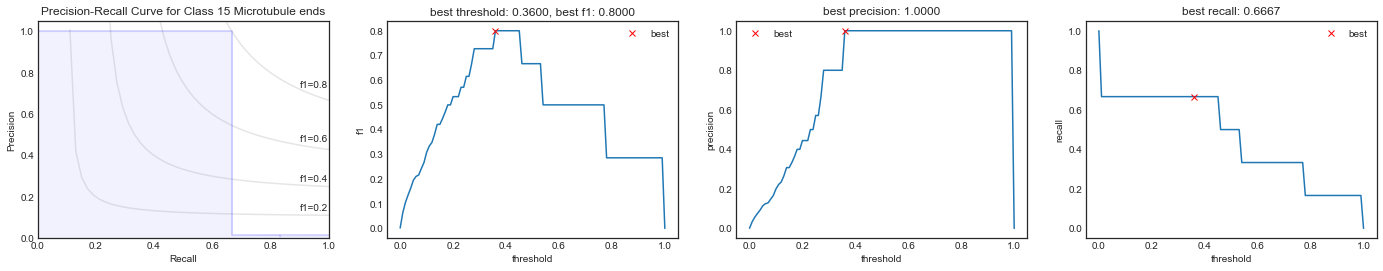

<Figure size 432x288 with 0 Axes>

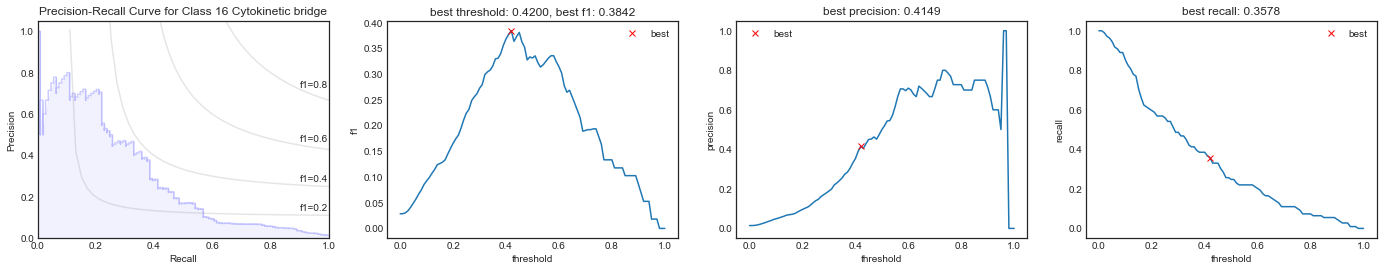

<Figure size 432x288 with 0 Axes>

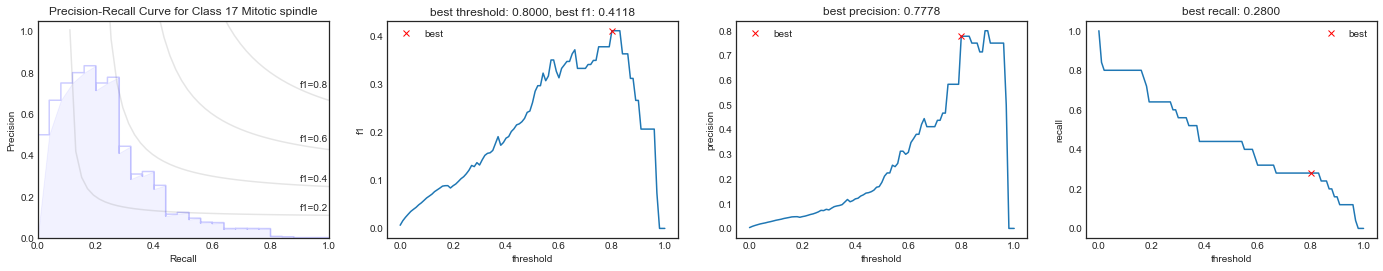

<Figure size 432x288 with 0 Axes>

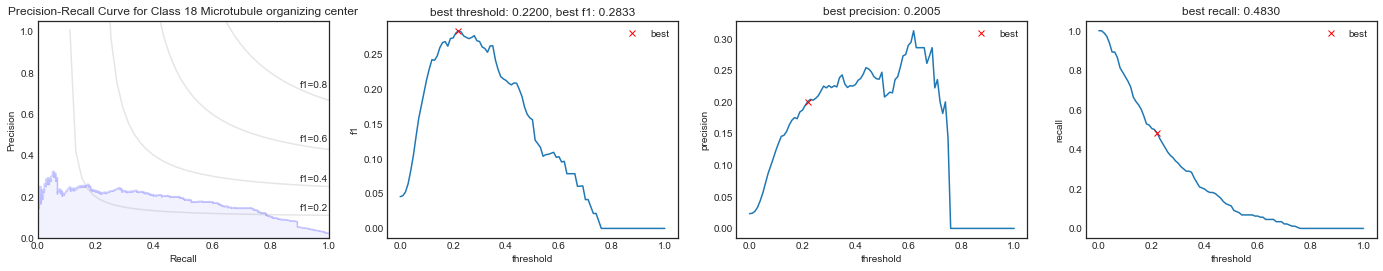

<Figure size 432x288 with 0 Axes>

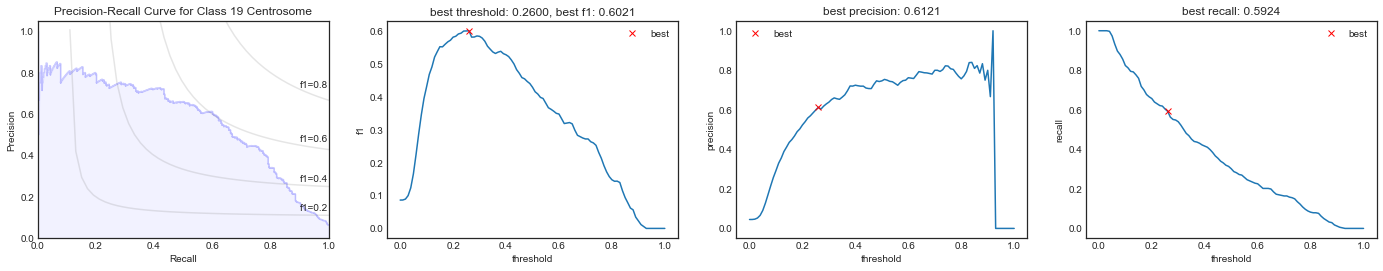

<Figure size 432x288 with 0 Axes>

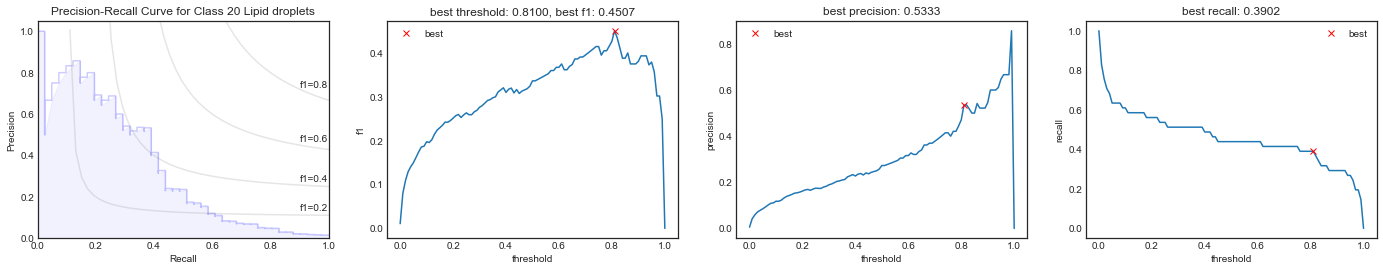

<Figure size 432x288 with 0 Axes>

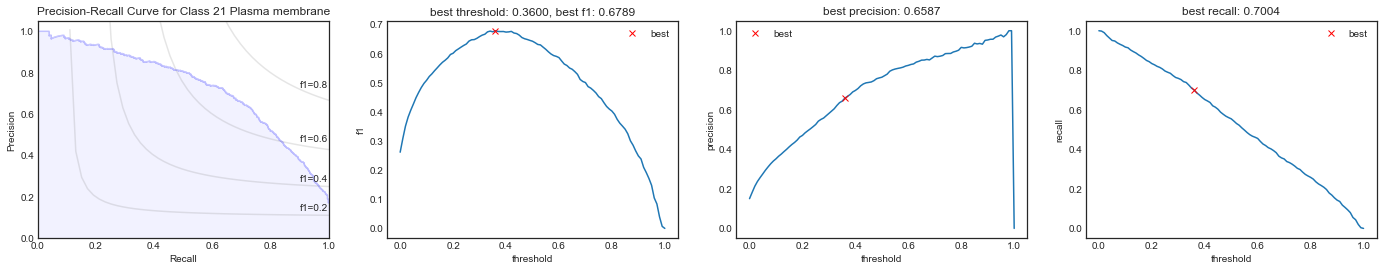

<Figure size 432x288 with 0 Axes>

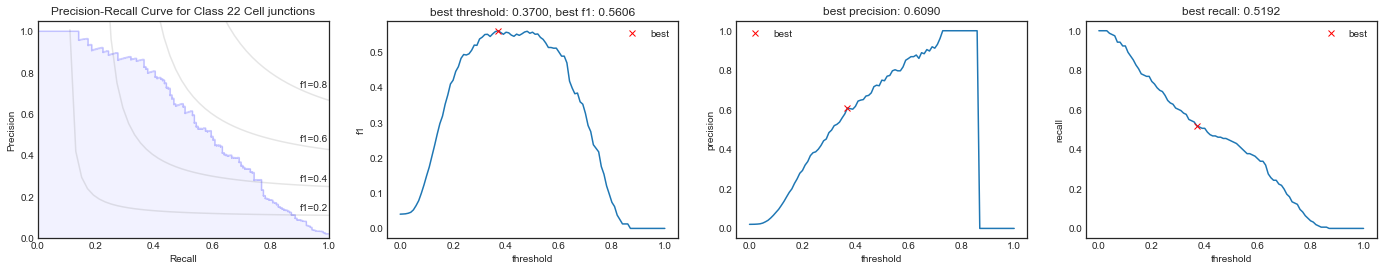

<Figure size 432x288 with 0 Axes>

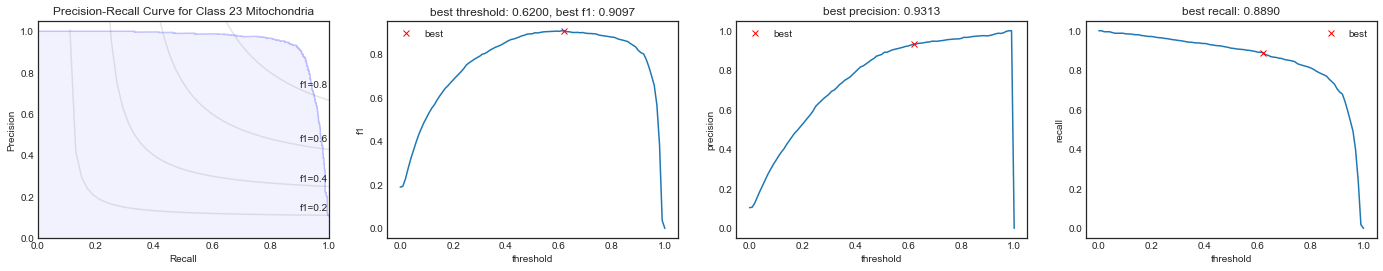

<Figure size 432x288 with 0 Axes>

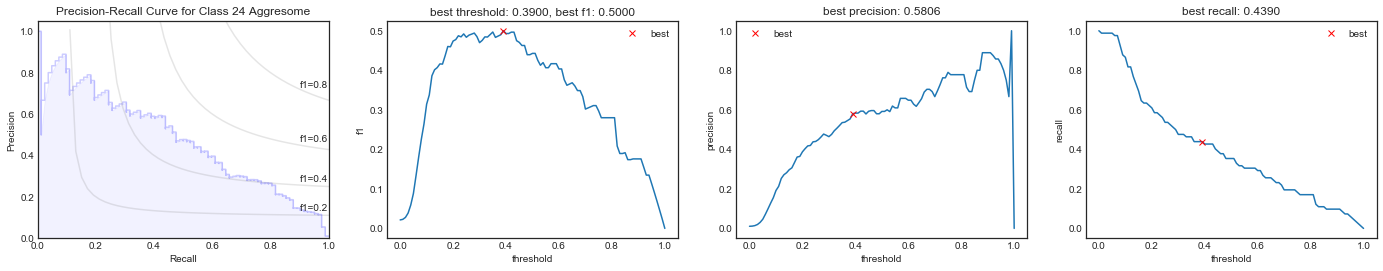

<Figure size 432x288 with 0 Axes>

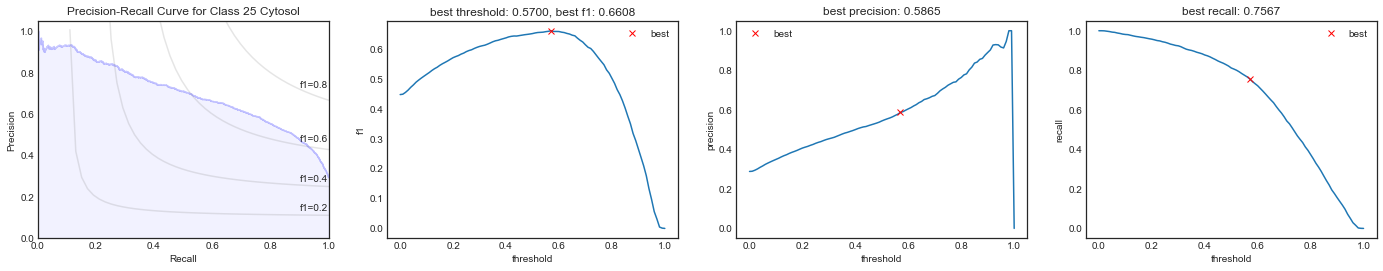

<Figure size 432x288 with 0 Axes>

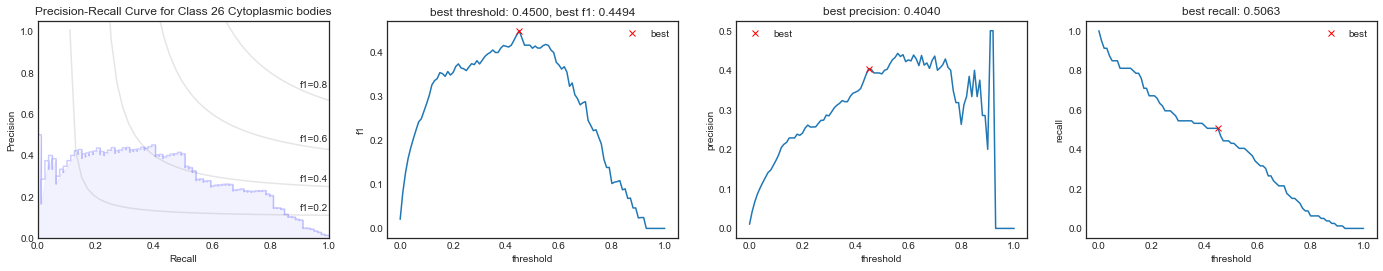

<Figure size 432x288 with 0 Axes>

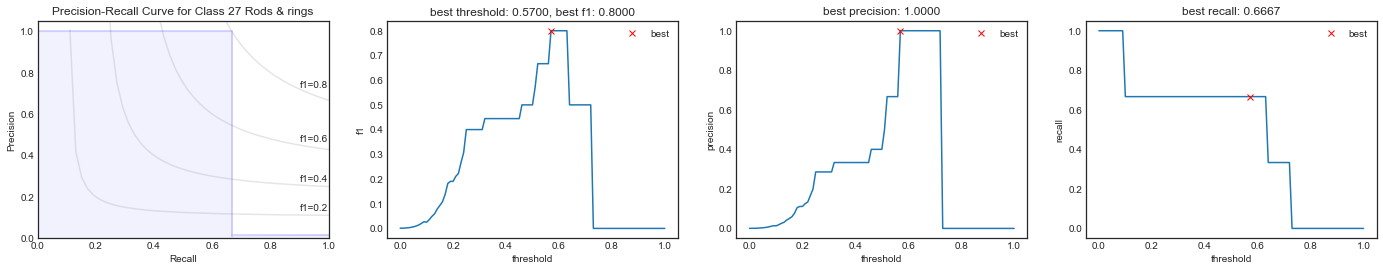

<Figure size 432x288 with 0 Axes>

In [99]:
n_classes = 28
thresholds = np.linspace(0.0, 1.0, 101)

# plot precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
f_scores = np.linspace(0.2, 0.8, num=4)
ta = []
fma = []

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(yoof[:, i], pred[:, i])
    average_precision[i] = average_precision_score(yoof[:, i], pred[:, i])
    
#     plt.figure()
    
#     for f_score in f_scores:
#         xf = np.linspace(0.01, 1)
#         yf = f_score * xf / (2 * xf - f_score)
#         l, = plt.plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

#     plt.step(recall[i], precision[i], color='b', alpha=0.2, where='post')
#     plt.fill_between(recall[i], precision[i], alpha=0.05, color='b')

#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title(LABEL_MAP[i])
    
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 4))
    
    for f_score in f_scores:
        xf = np.linspace(0.01, 1)
        yf = f_score * xf / (2 * xf - f_score)
        l, = axs[0].plot(xf[yf >= 0], yf[yf >= 0], color='gray', alpha=0.2)
        axs[0].annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, yf[45] + 0.02))

    axs[0].step(recall[i], precision[i], color='b', alpha=0.2, where='post')
    axs[0].fill_between(recall[i], precision[i], alpha=0.05, color='b')

    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_title('Precision-Recall Curve for Class ' + str(i) + ' ' + LABEL_MAP[i])
    
    
    # for ranks
    # thresholds = np.linspace(0.8, 1.0, 101)
    fm = [f1_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 

    besti = np.argmax(fm)
    bestt = thresholds[besti]
    ta.append(bestt)
    bests = fm[besti] 
    fma.append(bests)
        
    axs[1].plot(thresholds, fm)
    axs[1].plot(bestt, bests, "xr", label="best")
    axs[1].set_xlabel("threshold")
    axs[1].set_ylabel("f1")
    axs[1].set_title("best threshold: %6.4f, best f1: %6.4f" % (bestt, bests))
    axs[1].legend()

    pm = [precision_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 
    bestsp = pm[besti] 
        
    axs[2].plot(thresholds, pm)
    axs[2].plot(bestt, bestsp, "xr", label="best")
    axs[2].set_xlabel("threshold")
    axs[2].set_ylabel("precision")
    axs[2].set_title("best precision: %6.4f" % (bestsp))
    axs[2].legend()
    
    rm = [recall_score(yoof[:,i], (pred[:,i] > t).astype(int)) for t in thresholds] 
    bestsr = rm[besti] 
        
    axs[3].plot(thresholds, rm)
    axs[3].plot(bestt, bestsr, "xr", label="best")
    axs[3].set_xlabel("threshold")
    axs[3].set_ylabel("recall")
    axs[3].set_title("best recall: %6.4f" % (bestsr))
    axs[3].legend()
    
    plt.show()
    plt.gcf().clear()

In [100]:
np.mean(fma)

0.6989184174564791

In [101]:
# error analysis
from sklearn.metrics import confusion_matrix

cm = [confusion_matrix(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]
pma = [precision_score(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]
rma = [recall_score(yoof[:,i], (pred[:,i]  > th[i]).astype(int)) \
       for i in range(yoof.shape[1])]

print('macro f1','%6.4f' % np.mean(fma))
print()

# sort from worst to best
order = np.array(fma).argsort()
ymean = np.mean(yoof,axis=0)

for i in range(y.shape[1]):
    oi = order[i]
    print('class', '%2d' % oi,'  prop', '%6.4f' % ymean[oi], 
                     '  f1', '%6.4f' % fma[oi],
                     '  precision', '%6.4f' % pma[oi],
                     '  recall', '%6.4f' % rma[oi],
                     '  ', LABEL_MAP[oi])
    print(cm[oi])
    print()

macro f1 0.6989

class 18   prop 0.0233   f1 0.2833   precision 0.2010   recall 0.4716    Microtubule organizing center
[[7052  330]
 [  93   83]]

class 16   prop 0.0144   f1 0.3842   precision 0.4675   recall 0.3303    Cytokinetic bridge
[[7408   41]
 [  73   36]]

class 17   prop 0.0033   f1 0.4118   precision 0.7778   recall 0.2800    Mitotic spindle
[[7531    2]
 [  18    7]]

class 26   prop 0.0105   f1 0.4494   precision 0.4040   recall 0.5063    Cytoplasmic bodies
[[7420   59]
 [  39   40]]

class 20   prop 0.0054   f1 0.4507   precision 0.5333   recall 0.3902    Lipid droplets
[[7503   14]
 [  25   16]]

class 24   prop 0.0108   f1 0.5000   precision 0.5902   recall 0.4390    Aggresome
[[7451   25]
 [  46   36]]

class  6   prop 0.0266   f1 0.5479   precision 0.6098   recall 0.4975    Endoplasmic reticulum
[[7293   64]
 [ 101  100]]

class 22   prop 0.0206   f1 0.5606   precision 0.6148   recall 0.5321    Cell junctions
[[7350   52]
 [  73   83]]

class 19   prop 0.0451   f1 0

In [102]:
# confusion matrix of true val with single label
true_list = []
pred_list = []
for i, yi in enumerate(yoof):
#     img, y = db_val[i]

    true = np.nonzero(yi)[0]
    if len(true) > 1: continue
    
    predi = np.nonzero((pred[i] > threshold_best).astype(int))[0]
    if len(predi)==0: predi = np.array([28])
    # replace empty with max prob
    # if len(pred)==0: pred = [np.argmax(vlsp[i])]
    for j in range(len(predi)):
        true_list.append(true[0])
        pred_list.append(predi[j])
    
print(y.shape[0],len(true_list),len(pred_list))

true = np.array(true_list)
predc = np.array(pred_list)
print(true.shape,true[:5])

np.set_printoptions(linewidth=250)
cm = confusion_matrix(true,predc)
print(cm)

31072 5731 5731
(5731,) [ 0  7 11  7  7]
[[480   9  41   4  20  13   0  10   0   0   0   2   0   8   2   6   1   1   2   6   0   0   5   0  75   2   0   0]
 [ 29  38   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   9   0   0   0]
 [ 52   0  52   3   0   0   0   3   0   0   0   0   0   2   6   0   1   0   0   0   0   0   0   0  34   0   0   0]
 [ 20   0   7  17   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  20   1   1   1]
 [156   0   7   0 243   3   0   2   0   0   0   1   0   0   0   0   0   0   1   0   0   0   1   2  10   1   0   0]
 [111   2   3   2  10  92   0   2   0   0   0   0   1   0   0   1   0   1   2   0   2   0   3   0  73   0   0   0]
 [ 20   1   0   0   0   0  61   0   0   0   0   1   0   0   1   0   0   0   0   0   2   0   0   0  34   0   0   0]
 [106   2  13   0   5   0   3 568   0   0   0   9   0   1   1   6   0   1   0  17   1   2  41   7  28   5   0  20]
 [  4   0   2   0   0   0   0   0   4  

In [103]:
# compute test predictions
weights = pickle.load(open('weights/'+mname+'_'+str(fold)+'.pkl','rb'))
print(len(weights))

28


In [104]:
weights

[      weight                       mod      f1_0
 midx                                            
 0          3                   air_m68  0.831174
 1          5                  airx_m67  0.833735
 2          6                  cbam_m67  0.830502
 3          3             preresnet_m67  0.826684
 7          2     airnext50_gwap_ch_030  0.826647
 8          3  bn_inception_wgap_ch_042  0.830308
 9          2         dpn68_gwap_ch_030  0.828268
 10         1      resnet34_gwap_ch_042  0.817106,
       weight                    mod      f1_0
 midx                                         
 2          1               cbam_m67  0.798345
 5          1   airnet50_gwap_ch_028  0.819058
 7          1  airnext50_gwap_ch_030  0.829822,
       weight                    mod      f1_0
 midx                                         
 0          2                air_m68  0.747409
 1          1               airx_m67  0.737454
 3          1          preresnet_m67  0.746072
 5          1   airnet50_gwa

In [105]:
# list of unique model names

# allm = weights['mod'].values
# mnames = list(allm)

allm = [weights[i]['mod'].values for i in range(len(weights))]
mnames = list(set().union(*allm))

print(mnames)
print(len(mnames))

['se_resnext50_gwap_ch_030', 'airnet50_gwap_ch_018', 'air_m68', 'airx_m67', 'airnet50_gwap_ch_028', 'cbam_m67', 'airnext50_gwap_ch_030', 'resnet34_gwap_ch_042', 'airnext50_gwap_ch_018', 'dpn68_gwap_ch_030', 'preresnet_m67', 'bn_inception_wgap_ch_042']
12


In [106]:
blist = ['blend_0459']
tlist = ['iv3_a4','se_resnext_d10','se_resnext_d11']
klist = ['resnet34_46','resnet50','resnet34']
print(glist)
print(dlist)
print(blist)
print(tlist)
print(klist)

['air_m68', 'airx_m67', 'cbam_m67', 'preresnet_m67']
['airnet50_gwap_ch_018', 'airnet50_gwap_ch_028', 'airnext50_gwap_ch_018', 'airnext50_gwap_ch_030', 'bn_inception_wgap_ch_042', 'dpn68_gwap_ch_030', 'resnet34_gwap_ch_042', 'se_resnext50_gwap_ch_030']
['blend_0459']
['iv3_a4', 'se_resnext_d10', 'se_resnext_d11']
['resnet34_46', 'resnet50', 'resnet34']


In [107]:
name_label_dict = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}
LABEL_MAP = name_label_dict
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [108]:
test_df = pd.read_csv("sample_submission.csv", index_col="Id")
print(test_df.head())
print(test_df.shape)

                                      Predicted
Id                                             
00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0
(11702, 1)


In [109]:
test_df.columns

Index(['Predicted'], dtype='object')

In [110]:
# save a base copy for reuse below
test_df0 = test_df.copy()
sub_dir = './sub/'

In [111]:
# build blend as weighted average
test_df = test_df0.copy()
idx = test_df.index.values
num_classes = 28
firstm = True
sumw = 0.
d = 0
for m in mnames:

    firstf = True
    navg = 0
    if m in blist: suffix = '.npy'
    elif m in klist: suffix = '.pkl'
    else: suffix = '_mm.pkl'
    if True:
#     for fold in range(nfold):
#         print('')
#         print(m+'_'+str(fold))
        first = True
        nr = 0
        for rep in ['']:
            if m in blist:
                fname = sub_dir + m + rep + suffix
                if fold > 0: fname = fname + '_' + str(fold)
            elif m in dlist:
                if dlist0[d] == 'bn_inception_wgap': s = '_emb'
                else: s = '_extra_emb'
                fname = 'oof/Dmytro/'+dlist0[d]+s+'__fold_'+ \
                                str(fold)+'_'+dlist1[d]+'_test.csv'
            else:
                fname = sub_dir + m + rep + '_' + str(fold) + suffix
            if os.path.exists(fname):
                print()
                print(fname)
                if m in blist:
                    ptestb = np.load(fname)
                    idb = idb0
                elif m in klist: 
                    idb, ptestb = pickle.load(open(fname,'rb'))
                    # ptestb = logit(ptestb)
                elif m in tlist:
                    idb, ptestba, ptestb, ptestbb = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                elif m in dlist:
                    o = pd.read_csv(fname)
                    idb = list(o['Id'])
                    ptestb = np.array(o.iloc[:,:num_classes])
                    ptestb = expit(ptestb)
                elif m in glist:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = np.percentile(ptestb, gpct, axis=(2,3))
                    ptestb = 1./(1. + np.exp(-ptestb/gscale))
                else:
                    idb, ptestb, ptestba = pickle.load(open(fname,'rb'))
                    ptestb = expit(ptestb)
                
                # ptestb = np.clip(ptestb,-20.0,20.0)
                # ptestb[ptestb==-inf] = -6.0
                # ptestb[ptestb==inf] = 6.0
                
                print(ptestb.min(),ptestb.mean(),ptestb.max())
                
                if first:
                    ptestf = ptestb.copy()
                    idb0 = idb
                    first = False
                else:
                    checki = [i0 != i1 for i0,i1 in zip(idb0,idb)]
                    si = np.array(checki).sum()
                    # print(si)
                    assert si == 0
                    print(np.corrcoef(np.array(ptestf).flatten(),
                                      np.array(ptestb).flatten()))

                    ptestf += ptestb
                nr += 1
                
        if nr > 0:
            ptestf /= nr
            print(ptestf.shape,ptestf.min(),ptestf.mean(),ptestf.max())

            if firstf:
                id = idb
                ptest = ptestf.copy()
                firstf = False
            else:
                print(np.corrcoef(np.array(ptest).flatten(),
                                  np.array(ptestf).flatten()))
                ptest += ptestf
                
            navg += 1
    
    if navg != 1: raise ValueError('Found %d folds for %s instead of %d' % (navg,m,nfold))
    ptest /= navg
    pmask = (ptest > threshold).astype(int)
    print(m,navg,ptest.shape,ptest.min(),ptest.mean(),ptest.max(),pmask.mean())
    td = pd.DataFrame({'id':id})
    td[m] = [a for a in ptest]
    td.set_index('id',inplace=True)
    test_df = test_df.join(td)
    if m in dlist: d += 1



oof/Dmytro/airnet50_gwap_extra_emb__fold_0_ch_018_test.csv
3.0531266873810647e-13 0.05707361926508661 0.9999997709025158
(11702, 28) 3.0531266873810647e-13 0.0570736192650866 0.9999997709025158
se_resnext50_gwap_ch_030 1 (11702, 28) 3.0531266873810647e-13 0.0570736192650866 0.9999997709025158 0.044702370779109796

oof/Dmytro/airnet50_gwap_extra_emb__fold_0_ch_028_test.csv
3.4751276387656413e-13 0.05791103310260365 0.9999998131087963
(11702, 28) 3.4751276387656413e-13 0.05791103310260365 0.9999998131087963
airnet50_gwap_ch_018 1 (11702, 28) 3.4751276387656413e-13 0.05791103310260365 0.9999998131087963 0.046301609004565765

./sub/air_m68_0_mm.pkl
2.0611536181902037e-09 0.11498248121426506 0.9999998771943275
(11702, 28) 2.0611536181902037e-09 0.11498248121426506 0.9999998771943275
air_m68 1 (11702, 28) 2.0611536181902037e-09 0.11498248121426506 0.9999998771943275 0.09903679468711087

./sub/airx_m67_0_mm.pkl
2.8885881194064612e-08 0.13353183136182992 0.9999994296429602
(11702, 28) 2.88858

In [112]:
test_df.columns

Index(['Predicted', 'se_resnext50_gwap_ch_030', 'airnet50_gwap_ch_018',
       'air_m68', 'airx_m67', 'airnet50_gwap_ch_028', 'cbam_m67',
       'airnext50_gwap_ch_030', 'resnet34_gwap_ch_042',
       'airnext50_gwap_ch_018', 'dpn68_gwap_ch_030', 'preresnet_m67',
       'bn_inception_wgap_ch_042'],
      dtype='object')

In [113]:
print(idx[:5])

['00008af0-bad0-11e8-b2b8-ac1f6b6435d0' '0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '0006faa6-bac7-11e8-b2b7-ac1f6b6435d0' '0008baca-bad7-11e8-b2b9-ac1f6b6435d0'
 '000cce7e-bad4-11e8-b2b8-ac1f6b6435d0']


In [114]:
f = []
clist = list(test_df.columns[1:])
for c in clist:
    ff = np.array(list(test_df[c])).flatten()
    print(ff.shape,c)
    f.append(ff)
# print(clist)
r = np.corrcoef(f)
print(r)

(327656,) se_resnext50_gwap_ch_030
(327656,) airnet50_gwap_ch_018
(327656,) air_m68
(327656,) airx_m67
(327656,) airnet50_gwap_ch_028
(327656,) cbam_m67
(327656,) airnext50_gwap_ch_030
(327656,) resnet34_gwap_ch_042
(327656,) airnext50_gwap_ch_018
(327656,) dpn68_gwap_ch_030
(327656,) preresnet_m67
(327656,) bn_inception_wgap_ch_042
[[1.    0.962 0.781 0.775 0.941 0.764 0.928 0.914 0.938 0.839 0.775 0.849]
 [0.962 1.    0.784 0.773 0.935 0.766 0.935 0.914 0.936 0.837 0.778 0.846]
 [0.781 0.784 1.    0.889 0.784 0.861 0.784 0.787 0.787 0.813 0.889 0.8  ]
 [0.775 0.773 0.889 1.    0.775 0.873 0.773 0.773 0.776 0.824 0.884 0.81 ]
 [0.941 0.935 0.784 0.775 1.    0.764 0.96  0.916 0.938 0.835 0.775 0.847]
 [0.764 0.766 0.861 0.873 0.764 1.    0.764 0.768 0.767 0.811 0.861 0.796]
 [0.928 0.935 0.784 0.773 0.96  0.764 1.    0.913 0.933 0.83  0.776 0.836]
 [0.914 0.914 0.787 0.773 0.916 0.768 0.913 1.    0.928 0.847 0.782 0.837]
 [0.938 0.936 0.787 0.776 0.938 0.767 0.933 0.928 1.    0.852 0.7

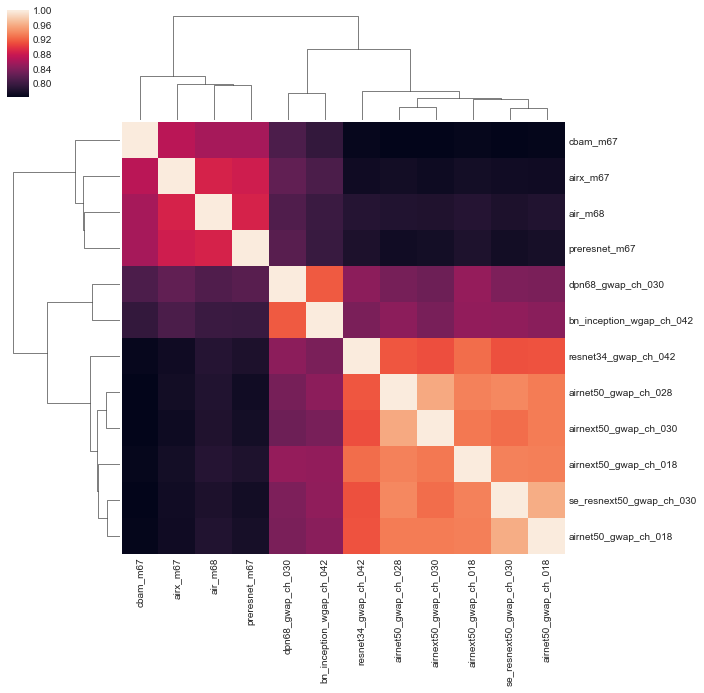

In [115]:
d = pd.DataFrame(r, columns=mnames)
d['id'] = mnames
d.set_index('id',inplace=True)
del d.index.name

sns.clustermap(d)


# import scipy.cluster.hierarchy as hc
# from matplotlib import pyplot
# link = hc.linkage(d.values, method='centroid')
# o1 = hc.leaves_list(link)

# mat = d.iloc[o1,:]
# mat = mat.iloc[:, o1[::-1]]
# pyplot.imshow(mat)

In [116]:
flat = np.transpose(np.array(f))
print(flat.shape)
fname = 'flat.csv'
fdf = pd.DataFrame(flat)
fdf.columns = clist
fdf.to_csv(fname)
print(fname)

(327656, 12)
flat.csv


In [117]:
ens = np.zeros((test_df.shape[0],28))

# apply class-specific ensemble weights
for i in range(28):

    f = []
#     clist = weights['mod'].values
    clist = weights[i]['mod'].values
    for c in clist:
        f.append(np.array(list(test_df[c])))
    m = np.array(f)
    print(m.shape)

#     w = np.array(weights['weight'].values)
    w = np.array(weights[i]['weight'].values)
    print(i, clist, w)

    ens[:,i] = np.average(m,axis=0,weights=w)[:,i]
    
print(ens.shape)

(8, 11702, 28)
0 ['air_m68' 'airx_m67' 'cbam_m67' 'preresnet_m67' 'airnext50_gwap_ch_030' 'bn_inception_wgap_ch_042'
 'dpn68_gwap_ch_030' 'resnet34_gwap_ch_042'] [3 5 6 3 2 3 2 1]
(3, 11702, 28)
1 ['cbam_m67' 'airnet50_gwap_ch_028' 'airnext50_gwap_ch_030'] [1 1 1]
(5, 11702, 28)
2 ['air_m68' 'airx_m67' 'preresnet_m67' 'airnet50_gwap_ch_028' 'airnext50_gwap_ch_018'] [2 1 1 1 1]
(6, 11702, 28)
3 ['air_m68' 'airx_m67' 'preresnet_m67' 'airnet50_gwap_ch_018' 'airnext50_gwap_ch_018'
 'airnext50_gwap_ch_030'] [1 2 1 5 3 1]
(7, 11702, 28)
4 ['air_m68' 'cbam_m67' 'airnet50_gwap_ch_028' 'airnext50_gwap_ch_018' 'airnext50_gwap_ch_030'
 'dpn68_gwap_ch_030' 'resnet34_gwap_ch_042'] [2 3 7 3 5 1 2]
(9, 11702, 28)
5 ['airx_m67' 'airnet50_gwap_ch_018' 'airnet50_gwap_ch_028' 'airnext50_gwap_ch_018'
 'airnext50_gwap_ch_030' 'bn_inception_wgap_ch_042' 'dpn68_gwap_ch_030' 'resnet34_gwap_ch_042'
 'se_resnext50_gwap_ch_030'] [1 2 1 1 1 3 3 1 4]
(3, 11702, 28)
6 ['airnet50_gwap_ch_018' 'airnext50_gwap_ch_018'

In [118]:
print(ens[1])

[0.399 0.003 0.042 0.027 0.026 0.784 0.023 0.036 0.    0.001 0.001 0.045 0.027 0.009 0.027 0.
 0.042 0.048 0.053 0.035 0.001 0.128 0.028 0.074 0.008 0.592 0.017 0.   ]


In [119]:
ens.shape

(11702, 28)

In [120]:
test_ids = list(test_df.index.values)
print(len(test_ids))

11702


In [121]:
sub = [list(test_df.index.values), ens]
fname = 'sub/'+mname+'_'+str(fold)+'.pkl'
pickle.dump(sub,open(fname,'wb'))
print(fname)

sub/hill_m94_0.pkl
